# Pythonで学ぶ画像認識　第6章 画像キャプショニング
## 第6.5節 Transformerによる画像キャプショニングを実装してみよう

### ライブラリの準備

###モジュールのインポートとGoogleドライブのマウント

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
from tqdm.notebook import tqdm
import pickle
import random
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import skimage.transform
from collections import deque

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as dataset

from timm.scheduler import CosineLRScheduler

# 認識エラー率を計算するモジュールをインポート
import levenshtein

#from google.colab import drive
#drive.mount('/content/drive')

import sys
sys.path.append('6_5_transformer_captioning')

import util
import model

### 位置エンコーディングの実装

In [2]:
class PositionalEncoding(nn.Module):
    '''
    位置エンコーディング （Positional encoding）
    dim_embedding: 埋込み次元
    dropout      : ドロップアウト確率
    max_len      : 入力の最大系列長
    temperature  : 温度定数
    '''
    def __init__(self, dim_embedding: int, dropout: float=0.1,
                 max_len: int=5000, temperature=10000):
        super().__init__()

        assert dim_embedding % 2 == 0

        self.dropout = nn.Dropout(p=dropout)

        dim_t = torch.arange(0, dim_embedding, 2)
        dim_t = dim_t / dim_embedding
        dim_t = temperature ** dim_t

        x_encoding = torch.arange(max_len).unsqueeze(1)
        x_encoding = x_encoding / dim_t

        # 位置情報を保持するテンソル
        #config = ConfigTrain()
        pe = torch.zeros((max_len, dim_embedding) )
        pe[:, ::2] = x_encoding.sin()
        pe[:, 1::2] = x_encoding.cos()

        # PEをメモリに保存
        self.register_buffer('pe', pe)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        #print( "device of x", x.device)
        #print( "device of self.pe", self.pe.device)
        x = x + self.pe[:seq]
        x = self.dropout(x)

        return x

### Transformerデコーダの実装

In [3]:
class TransformerDecoderLayer(nn.Module):
    '''
    Transformerデコーダ層
    dim_hidden     : 特徴量次元
    num_heads      : アテンションヘッドの数
    dim_feedforward: FNNの中間特徴量次元
    dropout        : ドロップアウト確率
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 dim_feedforward: int=2048, dropout: int=0.1):
        super().__init__()

        # 単語ベクトルに対するマルチヘッド自己アテンション
        self.self_attention = nn.MultiheadAttention(
            dim_hidden, num_heads, dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim_hidden)
        self.dropout1 = nn.Dropout(dropout)

        # エンコーダとデコーダ中間出力に対するマルチヘッドアテンション
        self.cross_attention = nn.MultiheadAttention(
            dim_hidden, num_heads, dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim_hidden)
        self.dropout2 = nn.Dropout(dropout)

        # FNN＆レイヤー正規化
        self.fnn = nn.Sequential(
            nn.Linear(dim_hidden, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, dim_hidden)
        )
        self.norm3 = nn.LayerNorm(dim_hidden)
        self.dropout3 = nn.Dropout(dropout)

    '''
    Transformerデコーダ層の順伝播
    tgt     : デコーダへの入力系列,
              [バッチサイズ, 系列長, 埋め込み次元]
    memory  : エンコーダ層の特徴量, [バッチサイズ, 1, 埋め込み次元]
    tgt_mask: 入力系列のマスク, [系列長, 系列長]
    '''
    def forward(self, tgt: torch.Tensor, memory: torch.Tensor,
                tgt_mask: torch.Tensor=None):

        # デコーダ入力に対するマスク付きマルチヘッド自己アテンション
        tgt2 = self.self_attention(
            query=tgt, key=tgt, value=tgt, attn_mask=tgt_mask)[0]
        tgt = tgt + self.dropout1(tgt2)  # 残差接続
        tgt = self.norm1(tgt)            # レイヤー正規化

        # エンコーダとデコーダ中間出力に対するマルチヘッド交差アテンション
        tgt2 = self.cross_attention(
            query=tgt, key=memory, value=memory)[0]
        tgt = tgt + self.dropout2(tgt2)  # 残差接続
        tgt = self.norm2(tgt)            # レイヤー正規化

        # FNN&レイヤー正規化
        tgt2 = self.fnn(tgt)
        tgt = tgt + self.dropout3(tgt2)  # 残差接続
        tgt = self.norm3(tgt)            # レイヤー正規化

        return tgt

### CaptioningTransformerの実装

In [18]:
class CaptioningTransformer(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    null_index     : NULLのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, vocab_size: int,
                 null_index: int, word_to_id: list, id_to_word: list, 
                 us_rate: float=2.0, dropout: float=0.5, iter_max: int=10):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(
            vocab_size, dim_embedding, padding_idx=null_index)

        # 位置エンコーディング
        self.positional_encoding = PositionalEncoding(dim_embedding)

        # Transformerデコーダ
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(
                dim_embedding, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        # 単語出力分布計算
        self.linear = nn.Linear(dim_embedding, vocab_size)

        # パラメータ初期化
        self._reset_parameters()
        
        # lengths_predictor の全結合
        self.length_linear = nn.Linear( dim_embedding, 1 )
        
        self.word_to_id = word_to_id
        self.id_to_word = id_to_word
        self.iter_max = iter_max
        self.us_rate = us_rate

    '''
    パラメータの初期化関数
    '''
    def _reset_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
            elif isinstance(module, nn.LayerNorm):
                nn.init.zeros_(module.bias)
                nn.init.ones_(module.weight)

    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]
    '''
    def forward(self, features: torch.Tensor,
                captions: torch.Tensor, lengths: float, is_inference = False, n_times = 0 ):
        seq = captions.shape[1]

        #print( "is_inference:", is_inference )
        if is_inference == False:
            caption_lengths = lengths
            lengths = self.lengths_predictor( features )
        else:
            lengths = lengths
            caption_lengths = lengths
        
        #print( "lengths:", lengths )
        
        # 単語埋め込み [バッチサイズ, 系列長]
        # -> [バッチサイズ, 系列長, 埋め込み次元]
        embeddings = self.embed(captions)
        
        embeddings, us_lengths = self.upsample( embeddings, caption_lengths )
            
        #print( " size of embeddings:", embeddings.size() )
        
        # 位置エンコーディング
        embeddings = self.positional_encoding(embeddings)

        features = features.unsqueeze(1)

        # 未来のキャプションを参照しないようにマスク行列を生成
        #tgt_mask = torch.tril(features.new_ones((seq, seq)))
        #tgt_mask = tgt_mask == 0

        # Transformerデコーダでキャプション生成
        # 画像の特徴も入力する
        for layer in self.decoder_layers:
            #embeddings = layer(embeddings, features, tgt_mask)
            embeddings = layer(embeddings, features, tgt_mask=None)
            
        # [バッチサイズ, 系列長, 埋め込み次元]
        # -> [バッチサイズ, 系列長, 辞書の次元]
        preds = self.linear(embeddings)
        
        #print( "argmax of preds[0]:", torch.argmax( preds[0], dim = 1 ) )

        return preds, lengths, us_lengths

    def upsample(self, enc_out, input_lengths ):

        #print( "self.us_rate:",self.us_rate)
        max_label_length = int( round( enc_out.size(1) * self.us_rate ) )

        polated_lengths = torch.round( torch.ones( enc_out.size(0) ) * enc_out.size(1) * self.us_rate ).long()

        outputs_lens = torch.round( input_lengths * self.us_rate ).long()
        #print( "size of  outputs_lens:", outputs_lens.size() )
        #print( "input_lengths:", input_lengths )
        #print( "input_lengths * self.us_rate:", input_lengths * self.us_rate )
        #print( "outputs_lens:", outputs_lens )
        #print( "output_lens", outputs_lens)

        x = enc_out
        out_lens = polated_lengths

        y = torch.tensor( [], device = enc_out.device  )
        #outputs_lens = torch.tensor( [] )
        
        for i in range( x.size(0) ):
            x0 = torch.unsqueeze( x[i], dim = 0 )
            x0 = x0.permute( 0,2,1)
            x_out = torch.nn.functional.interpolate(x0, size = (out_lens[i]), mode='nearest-exact')
            #outputs_lens = torch.cat( [outputs_lens, torch.unsqueeze( out_lens[i], dim = 0 ) ], dim = 0 )
            z = torch.zeros( (x_out.size(0), x_out.size(1), max_label_length), device = enc_out.device )
            if z.size(2) > x_out.size(2):
                z[:,:,:x_out.size(2)] = x_out[:,:,:]
            else:
                z[:,:,:] = x_out[:,:,:z.size(2)]
            x_out = z.permute( 0, 2, 1 )
            y = torch.cat( [y, x_out], dim = 0)
            
        return y, outputs_lens.to(torch.int32)
    
    
    def lengths_predictor(self, features):
        
        x = self.length_linear( features )
        lengths = torch.squeeze( x, dim = 1 )
        
        return lengths

    '''
    CaptioningTransformerのサンプリング処理
    features  : 画像特徴ベクトル [バッチサイズ, 埋め込み次元]
    word_to_id: 単語->単語ID辞書
    max_length: 最大キャプション長
    '''
    @torch.no_grad()
    def sample(self, features: torch.Tensor, word_to_id: list,
               max_length: int=30):
        bs = features.shape[0]

        # <start> トークンで出力キャプションを初期化
        captions = features.new_full(
            (bs, 1), word_to_id['<start>'], dtype=torch.int64)

        # 単語を逐次予測
        for _ in range(max_length):
            preds = self.forward(features, captions)
            preds = preds[:, -1]
            preds = preds.softmax(dim=1)
            words = preds.argmax(dim=1, keepdim=True)

            captions = torch.cat((captions, words), dim=1)

        return captions
    
    # 推論モジュール
    @torch.no_grad()
    def inference(self,
                enc_outs, is_inference = True
                #dec_input,
                #dec_input_lens
                ):
        ''' ネットワーク計算(forward処理)の関数
        input_sequence: 各発話の入力系列 [B x Tin x D]
        input_lengths:  各発話の系列長(フレーム数) [B]
          []の中はテンソルのサイズ
          B:    ミニバッチ内の発話数(ミニバッチサイズ)
          Tin:  入力テンソルの系列長(ゼロ埋め部分含む)
          D:    入力次元数(dim_in)
          Tout: 正解ラベル系列の系列長(ゼロ埋め部分含む)
        '''
        lengths = self.lengths_predictor( enc_outs ) + 2 # 推論の length は少し長めにしておいて、CTC に任せる。
        
        #print( "lengths:", lengths )
        #print( "size of lengths:", lengths.size())
        
        lengths = torch.clamp( lengths, min=1.0 ) 

        captions = torch.zeros( (enc_outs.size(0), int( torch.max( lengths) ) ) )
        
        #print( "size of captions:", captions.size() )
        
        # dec_input は <sos> <mask> <mask> ・・・ <mask> <eos> とする   
        #dec_input[:,0] = 8580 #<start>
        captions[:,0] = self.word_to_id['<start>'] #<start>
        for n in range( captions.size(0) ):
            #print( "length[n] - 1 :{}".format( int( length[n] ) - 1 ))
            #print( "size of dec_input:{}".format( dec_input.size() ) )
            if int( lengths[n] ) >= 3:
                #dec_input[n, int( lengths[n] ) - 1  ] = 8581 #<end>
                #dec_input[n, int( lengths[n] ) - 1  ] = self.word_to_id['<end>'] #<end>
                captions[n, int( lengths[n] ) - 1  ] = self.word_to_id['<mask>'] #<end>
                captions[n, 1: int( lengths[n] )  - 2 ] = self.word_to_id['<mask>'] #<mask>
            else:
                #dec_input[n, 1] = 13579 #<end>
                cpations[n,1] = self.word_to_id['<mask>']
                    
        #outputs = captions
        i = 0
        #print( "i:{}, outputs:{}".format( i, outputs[0] ) )
        iter_max = self.iter_max

        for i in range( iter_max - 1 ):
            # デコーダに入力する
            #print( "size of outputs:{}".format( outputs.size() ) )
            captions = captions.long()
            #print( "outputs size:", outputs.size() )
            #print( "captions:", captions )
            outputs,  _, _ = self.forward( enc_outs, captions.to(enc_outs.device), lengths, is_inference = is_inference)

            #print( outputs.size())
            outputs = torch.nn.functional.softmax( outputs, dim = 2 )
            
            #outputs2 = outputs.clone()
            
            tmp_captions = torch.tensor( [] )
            for n in range( outputs.size(0) ):
                caption0, probability0 = ctc_simple_inference( outputs[n], self.id_to_word )
                if (torch.max(lengths).to( torch.int32)) >= caption0.size(0):
                    caption = torch.ones( (torch.max(lengths).to( torch.int32)), device = caption0.device ) * self.word_to_id['<null>']
                    probability = torch.zeros( (torch.max(lengths).to( torch.int32)), device = caption0.device  )
                    caption[:caption0.size(0) ] = caption0
                    probability [:caption0.size(0)] = probability0
                else:
                    caption = caption0
                    probability = probability0
                num_zero = torch.sum( probability == 0.0 )
                #print( "num_zero:", num_zero )
                #kosuu = int( (i + 1 )  * lengths[n]  / (iter_max + 1 ) ) + num_zero
                kosuu = int( (iter_max - i )  * caption0.size(0)  / (iter_max + 1 ) ) + num_zero
                #print( "kosuu:", kosuu )
                sort_probability = torch.sort( probability, dim = 0 ).values
                #print( "sort_probability:", sort_probability )
                #print( "i=",i, ",n=",n, "length[n]=", length[n], " kosuu:{}".format( kosuu ) )
                if kosuu - 1 < 0:
                    kosuu = 1
                thresh = sort_probability[ kosuu - 1 ]
                #print( "thresh:", thresh )
                t_indices = probability[:]  < thresh
                #print( "<mask>:", self.word_to_id['<mask>'])
                caption[t_indices] = self.word_to_id['<mask>']
                #print( "caption:", caption)
                tmp_captions = torch.cat([ tmp_captions, torch.unsqueeze( caption, dim = 0 )], dim = 0 )

            captions = tmp_captions
        
        outputs,  _, _ = self.forward( enc_outs, captions.to(enc_outs.device).to(torch.int32 ), lengths, is_inference = is_inference)
        outputs = torch.argmax( outputs, dim = 2 )
        #print( "outputs:", outputs )
        #print( "i:{}, outputs:{}".format( i, outputs[0] ) )

        # デコーダ出力とエンコーダ出力系列長を出力する
        #print("dec_input:{}".format( dec_input ))
        #return logits
        return outputs, lengths


###学習におけるハイパーパラメータやオプションの設定

In [19]:
class ConfigTrain(object):
    '''
    ハイパーパラメータ、システム共通変数の設定
    '''
    def __init__(self):

        # ハイパーパラメータ
        self.dim_embedding = 512   # 埋め込み層の次元
        self.dim_feedforward = 2048 # FNNの中間特徴量次元
        self.num_heads = 8         # マルチヘッドアテンションのヘッド数
        self.num_layers = 12        # Transformerデコーダ層の層数
        #self.lr = 0.001            # 学習率
        self.lr = 0.005            # 学習率
        self.dropout = 0.3         # dropout確率
        self.batch_size = 100       # ミニバッチ数
        self.num_epochs = 100       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        self.us_rate = 2.0          # アップサンプリングの割合
        self.dropout = 0.5          # デコーダーで使う dropout の割合
        self.iter_max = 10          # inference でイタレーションする回数


        # パスの設定
        #self.img_directory = 'val2014'
        self.img_directory = 'train2017'
        #self.anno_file = 'drive/MyDrive/python_image_recognition/data/coco2014/captions_val2014.json'
        #self.word_to_id_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/word_to_id.pkl'
        #self.save_directory = 'drive/MyDrive/python_image_recognition/6_img_captioning/model'
        #self.anno_file = '../../data/coco2014/captions_val2014.json'
        self.anno_file = '../../data/coco2014/captions_train2017.json'
        #self.word_to_id_file = '../../6_img_captioning/model/best/word_to_id2.pkl'
        #self.id_to_word_file = '../../6_img_captioning/model/best/id_to_word2.pkl'
        self.word_to_id_file = '../../6_img_captioning/model/best/word_to_id5_train2017.pkl'
        self.id_to_word_file = '../../6_img_captioning/model/best/id_to_word5_train2017.pkl'
        self.save_directory = '../../6_img_captioning/model'

        # 検証に使う学習セット内のデータの割合
        #self.val_ratio = 0.3
        self.val_ratio = 0.1

        # データローダーに使うCPUプロセスの数
        self.num_workers = 4
        #self.num_workers = 0

        # 学習に使うデバイス
        self.device = 'cuda'
        #self.device = 'cpu'

        # 移動平均で計算する損失の値の数
        self.moving_avg = 100

### 学習率スケジューラ

In [20]:
linear = torch.nn.Linear(1, 1)
optimizer = torch.optim.AdamW(linear.parameters(), lr = 5e-3)
scheduler = CosineLRScheduler(
    optimizer, t_initial=100, lr_min=1e-4, warmup_t=20,
    warmup_lr_init=5e-5, warmup_prefix=True)

lrs = []
for i in range(100):
    lrs.append(scheduler.get_epoch_values(i))
plt.plot(lrs)
plt.title("CosineLRScheduler")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.grid()

In [21]:
def time_masking(dec_input: torch.Tensor, dec_input_lens: torch.Tensor, mask_id: int) -> tuple[torch.Tensor, torch.BoolTensor]:
    """
    Args:
        hidden_states (torch.Tensor): with shape `(B, L, D)`
        lengths (torch.Tensor): with shape `(B)`

    Returns:
        tuple(
        Masked hidden states (torch.Tensor with shape `(B, L, D)`),
        Time mask (torch.BoolTensor with `(B, L)`)
        )
    """
       
    mask = torch.zeros_like( dec_input, device=dec_input.device, dtype=bool )       
        
    for n in range( dec_input.size(0) ):
        m_max = torch.randint( low = 0, high = dec_input_lens[n], size=(1, ) )
        m = torch.randint( low = 0, high = dec_input_lens[n], size=(m_max,) )
        dec_input[n,m] = mask_id
        mask[n,m] = True
        
    return dec_input, mask


In [22]:
def ctc_simple_decode(int_vector, token_list):
    ''' 以下の手順で，フレーム単位のCTC出力をトークン列に変換する
        1. 同じ文字が連続して出現する場合は削除
        2. blank を削除
    int_vector: フレーム単位のCTC出力(整数値列)
    token_list: トークンリスト
    output:     トークン列
    '''
    #print( int_vector.device)
    #print( token_list[1])
    #print( token_lisg.device)
    
    #print( "en3:{}".format( len( token_list ) ) )
    #print( "en4:{}".format( token_list[9656] ) )
    #print( "en5:{}".format( token_list[9657] ) )
    # 出力文字列
    output = []
    # 一つ前フレームの文字番号
    prev_token = -1
    # フレーム毎の出力文字系列を前から順番にチェックしていく
    for n in int_vector:
        n = n.item()
        #print( "n:{}".format( n ) )
        #print( " n:{}".format( n ))
        #print( " prev_token:{}".format( prev_token ))
        if n != prev_token:
            # 1. 前フレームと同じトークンではない
            if n != 0:
                # 2. かつ，blank(番号=0)ではない
                # --> token_listから対応する文字を抽出し，
                #     出力文字列に加える
                #print( "n:{}".format( n ) )
                #output.append(token_list[str(n)])
                #if token_list[n] != "<sart>" and token_list[n] != "<end>" and token_list[n] != '.':
                #    output.append( " " + token_list[n])
                #else:
                output.append( token_list[n])
                if token_list[n] == '<end>':
                    break
            # 前フレームのトークンを更新
            prev_token = n
    return output

### 学習を行う関数

In [9]:
def train():
    config = ConfigTrain()

    # 辞書（単語→単語ID）の読み込み
    with open(config.word_to_id_file, 'rb') as f:
        word_to_id = pickle.load(f)
    word_to_id['<blank>'] = 0
    
    # 辞書（単語ID→単語）の読み込み
    with open(config.id_to_word_file, 'rb') as f:
        id_to_word = pickle.load(f)
    id_to_word[0] = '<blank>'

    # 辞書サイズを保存
    #print( "word_to_id['<mask>']:",word_to_id['<mask>'])
    vocab_size = len(word_to_id)
    #print( "vocab_size:", vocab_size)

    # モデル出力用のディレクトリを作成
    os.makedirs(config.save_directory, exist_ok=True)

    # 画像のtransformsを定義
    transforms = T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # COCOデータロードの定義
    train_dataset = dataset.CocoCaptions(root=config.img_directory,
                                         annFile=config.anno_file,
                                         transform=transforms)

    # Subset samplerの生成
    val_set, train_set = util.generate_subset(
        train_dataset, config.val_ratio)

    # 学習時にランダムにサンプルするためのサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    collate_func_lambda = lambda x: util.collate_func(x, word_to_id)
    train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=config.batch_size,
                        num_workers=config.num_workers,
                        sampler=train_sampler,
                        #sampler=val_set,
                        collate_fn=collate_func_lambda)
    val_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=config.batch_size,
                        num_workers=config.num_workers,
                        sampler=val_set,
                        collate_fn=collate_func_lambda)

    # モデルの定義
    encoder = model.CNNEncoder(config.dim_embedding)
    decoder = CaptioningTransformer(
        config.dim_embedding, config.dim_feedforward,
        config.num_heads, config.num_layers, vocab_size,
        word_to_id['<null>'],  word_to_id, id_to_word, 
        config.us_rate, config.dropout, config.iter_max )
    encoder.to(config.device)
    decoder.to(config.device)

    # 損失関数の定義
    #loss_func = lambda x, y: F.cross_entropy(
    #    x, y, ignore_index=word_to_id.get('<null>', None))
    criterion = nn.CTCLoss(blank=0, reduction='mean',zero_infinity=False) 

    # 最適化手法の定義
    params = list(decoder.parameters()) + \
    list(encoder.linear.parameters())
    optimizer = torch.optim.AdamW(params, lr=config.lr)

    # WarmupとCosine Decayを行うスケジューラを利用
    scheduler = CosineLRScheduler(
        optimizer, t_initial=config.num_epochs, lr_min=1e-4,
        warmup_t=20, warmup_lr_init=5e-5, warmup_prefix=True)

    # 学習経過の書き込み
    now = datetime.datetime.now()
    train_loss_file = '{}/6-73_train_loss_{}.csv'\
        .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
    val_loss_file = '{}/6-73_val_loss_{}.csv'\
        .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))

    # 学習
    val_loss_best = float('inf')
    for epoch in range(config.num_epochs):
        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 学習モードに設定
            encoder.train()
            decoder.train()

            train_losses = deque()
            train_errors = deque()
            #for imgs, captions, _ in pbar:
            total_error = 0
            total_token_length = 0
            n_batch = 0
            for imgs, captions, caption_lengths in pbar:
                # ミニバッチを設定
                imgs = imgs.to(config.device)
                captions = captions.to(config.device)
                caption_lengths = torch.tensor(caption_lengths).to(config.device)

                optimizer.zero_grad()

                # エンコーダ-デコーダモデル
                features = encoder(imgs)
                # 最後の単語から次を予測する必要はないため最後の単語を除外
                #captions_in = captions[:, :-1]
                masked_captions, mask = time_masking( captions.clone(), caption_lengths,  word_to_id['<mask>'] )
                #outputs = decoder(features, captions_in)
                #print( "caption_lengths:", caption_lengths )
                outputs, lengths, us_lengths = decoder(features, masked_captions, caption_lengths)
                hypo_ids = torch.argmax( outputs, dim = 2 )
                outputs = F.log_softmax( outputs, dim=2 )
                
                # 損失の計算
                # <start>の予測は行わないため除外
                #targets = captions[:, 1:]
                if n_batch % 300 == 299:
                    print( "argmax outputs[0]:", hypo_ids[0] )
                    #print( "captions[0]:", targets[0])
                    if torch.any( captions[0] == 0 ):
                        print( "captions[0] includes 0.")
                    print( "captions[0]:", captions[0])
                # 単語軸が第1軸である必要があるため、転置
                #outputs = outputs.transpose(1, 2)
                #loss = loss_func(outputs, targets)
                #loss0 = loss_func(outputs[mask], captions[mask])
                if torch.any( us_lengths < caption_lengths ):
                    print( "us_lengths < caption_lengths")
                    print( " us_lengths:", us_lengths )
                    print( " caption_lengths:", caption_lengths )
                loss0 = criterion( outputs.transpose(0, 1), captions, us_lengths, caption_lengths )
                loss1 = nn.MSELoss()( lengths, caption_lengths.to( torch.float32 ) )
                loss = loss0 + loss1
                
                # 誤差逆伝播
                loss.backward()

                optimizer.step()

                n = 0
                hypo_sentence = []
                ref_sentence = []
                #for hypo_id, caption in zip( hypo_ids, captions ):
                for (hypo_id, caption) in zip( hypo_ids, captions ):
                    hypo = ctc_simple_decode( hypo_id.to(device=config.device), id_to_word )                
                    #hypo = []
                    ##print( "len hypo_id:", len( hypo_id ))
                    #for m in hypo_id:
                    #    #print( "m:", m )
                    #    if id_to_word[m.item()] == '<end>':
                    #        break
                    #    hypo.append(id_to_word[m.item()])
                    ##print( "hypo:", hypo )
                    ## 正解の文字列を取得
                    reference = []
                    for m in caption:
                        reference.append(id_to_word[m.item()])
                        if id_to_word[m.item()] == '<end>':
                            break
                        
                    # 認識誤りを計算
                    (error, substitute, 
                     delete, insert, ref_length) = \
                        levenshtein.calculate_error(hypo,
                                                    reference)
                    #print( ' '.join(hypo) )
                    #print( '\n')
                    #print( ' '.join(reference ) )
                    #print( '\n')
                    
                    #print( "error:", error )
                    # 誤り文字数を累積する
                    total_error += error
                    # 文字の総数を累積する
                    total_token_length += ref_length

                    if n < 4 and n_batch == len( train_loader ) -1 :
                        hypo_sentence.append( ' '.join(hypo) )
                        ref_sentence.append( ' '.join(reference ) )
                    
                    n += 1
                
                n_batch += 1
                avg_error = total_error / total_token_length * 100
                #print( "avg_error:", avg_error )
                
                # 学習時の損失をログに書き込み
                train_losses.append(loss.item())
                train_errors.append( avg_error )
                if len(train_losses) > config.moving_avg:
                    train_losses.popleft()
                    train_errors.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(train_losses).mean().item(),
                    'WER': torch.Tensor(train_errors).mean().item()
                })
                with open(train_loss_file, 'a') as f:
                    print(f'{epoch}, {loss0.item()}, {loss1.item()}, {loss.item()}, {avg_error}', file=f)

            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )


        # 学習率を表示
        print(f'学習率: {scheduler.get_epoch_values(epoch)}')

        # 検証
        with tqdm(val_loader) as pbar:
            pbar.set_description(f'[検証]')

            # 評価モード
            encoder.eval()
            decoder.eval()

            val_losses = deque()
            val_errors = deque()
            total_error = 0
            total_token_length = 0
            n_batch = 0
            #for imgs, captions, _ in pbar:
            for imgs, captions, caption_lengths in pbar:
                # ミニバッチを設定
                imgs = imgs.to(config.device)
                captions = captions.to(config.device)
                caption_lengths = torch.tensor(caption_lengths).to(config.device)

                with torch.no_grad():                
                    # エンコーダ-デコーダモデル
                    features = encoder(imgs)
                    # 最後の単語から次を予測する必要はないため最後の単語を除外
                    #captions_in = captions[:, :-1]
                    masked_captions, mask = time_masking( captions.clone(), caption_lengths,  word_to_id['<mask>'] )
                    #outputs = decoder(features, captions_in)
                    outputs, lengths, us_lengths = decoder(features, masked_captions, caption_lengths)
                    hypo_ids = torch.argmax( outputs, dim = 2 )
                    outputs = F.log_softmax( outputs, dim=2 )

                # 損失の計算
                # <start>の予測は行わないため除外
                #targets = captions[:, 1:]
                # 単語軸が第1軸である必要があるため、転置
                #outputs = outputs.transpose(1, 2)
                #loss = loss_func(outputs, targets)
                #loss0 = loss_func(outputs[mask], captions[mask])
                loss0 = criterion( outputs.transpose(0, 1), captions, us_lengths, caption_lengths )
                loss1 = nn.MSELoss()( lengths, caption_lengths.to( torch.float32 ) )
                loss = loss0 + loss1
                val_losses.append(loss.item())

                if n_batch % 50 == 49:
                    print( "argmax outputs[0]:", hypo_ids[0] )
                    #print( "captions[0]:", targets[0])
                    print( "captions[0]:", captions[0])                         
                    
                n = 0
                hypo_sentence = []
                ref_sentence = []
                for (hypo_id, caption) in zip( hypo_ids, captions ):
                    hypo = ctc_simple_decode( hypo_id.to(device=config.device), id_to_word )      
                    #hypo = []
                    #for m in hypo_id:
                    #    if id_to_word[m.item()] == '<end>':
                    #        break
                    #    hypo.append(id_to_word[m.item()])
                    ## 正解の文字列を取得
                    reference = []
                    for m in caption:
                        reference.append(id_to_word[m.item()])
                        if id_to_word[m.item()] == '<end>':
                            break
                        
                    # 認識誤りを計算
                    (error, substitute, 
                     delete, insert, ref_length) = \
                        levenshtein.calculate_error(hypo,
                                                    reference)
                    
                    # 誤り文字数を累積する
                    total_error += error
                    # 文字の総数を累積する
                    total_token_length += ref_length


                    if n < 4 and n_batch == len( val_loader ) -1 :
                        hypo_sentence.append( ' '.join(hypo) )
                        ref_sentence.append( ' '.join(reference ) )
                    
                    n += 1
                
                n_batch += 1
                avg_error = total_error / total_token_length * 100                    

                val_losses.append(loss.item())
                val_errors.append(avg_error)
                
                if len(val_losses) > config.moving_avg:
                    val_losses.popleft()
                    val_errors.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(val_losses).mean().item(),
                    'WER': torch.Tensor(val_errors).mean().item()
                })                
                
                # Validation Lossをログに書き込み
                with open(val_loss_file, 'a') as f:
                    print(f'{epoch}, {loss0.item()}, {loss1.item()}, {loss.item()},  {avg_error}', file=f)
                    
            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )
                    
        # Loss 表示
        val_loss = np.mean(val_losses)
        print(f'Validation loss: {val_loss}')
        print(f'Validation WER: {avg_error}')

        # より良い検証結果が得られた場合、モデルを保存
        if val_loss < val_loss_best:
            val_loss_best = val_loss

            # エンコーダモデルを保存
            torch.save(
                {'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
                f'{config.save_directory}/6-73_encoder_best.pth')
            
            # デコーダモデルを保存
            torch.save(
                {'epoch': epoch,
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
                f'{config.save_directory}/6-73_decoder_best.pth')

            
        # エンコーダモデルを保存
        torch.save(
                {'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
            f'{config.save_directory}/6-73_encoder_curr.pth')
            
        # デコーダモデルを保存
        torch.save(
                {'epoch': epoch,
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
            f'{config.save_directory}/6-73_decoder_curr.pth')         

###学習データの解凍

In [ ]:
!unzip drive/MyDrive/python_image_recognition/data/coco2014/val2014.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: val2014/COCO_val2014_000000535608.jpg  
 extracting: val2014/COCO_val2014_000000279145.jpg  
 extracting: val2014/COCO_val2014_000000243495.jpg  
 extracting: val2014/COCO_val2014_000000225791.jpg  
 extracting: val2014/COCO_val2014_000000428067.jpg  
 extracting: val2014/COCO_val2014_000000059383.jpg  
 extracting: val2014/COCO_val2014_000000558498.jpg  
 extracting: val2014/COCO_val2014_000000376123.jpg  
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.jpg  
 extracting: v

###学習の実行

In [10]:
train()

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], device='cuda:0')
captions[0]: tensor([13578,     1,    98,   107,    33,   260,   414,   135,     7,   435,
          261,   112,    98,   107,    33,   260,   104,   135,     1,    76,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0, 13579,
        13579,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,   922,   482,   121,  1765,  1488,   213, 13580,  1903,  5026,
         2160,  2794,  5444, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    33,     1,
            1,     1,  2518,  2518,    37,     1,     1,     1,     1,  2518,
        13579,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     1,     1,     0,     0, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   263,   190,   144,     1,  2518,  3671,     4,    59,
          298,  1638,    13,   190,    47,    60,   463,   121,   228, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   420,     0,     0,     0,     0,   420,   420,
            1,     1,     1,     0,     1,     1,     1,     1,     1,    58,
        13579,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')
captions[0]: tensor([13578,     1,   277,   420,     4,    58,  3403,   562,   383,     7,
   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   375,     0,     0,     0,     0,     4,     4,
           47,    47,     1,     1,    13,     4,    47,     1,   375,   375,
        13579,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     1,     1,     1, 13579, 13579,     0],
       device='cuda:0')
captions[0]: tensor([13578,     1,   520,  5520,  4087,    47,     1,   335,  6099,     1,
         4087,  3996,   467, 13355,    13,   250,    47,     1,   375, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    33,     1,
           33,    13,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,     1,     7,     1, 13579,     0,     0,
            0,     0,     0,     0,     0,     1,     0, 13579],
       device='cuda:0')
captions[0]: tensor([13578,   

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,   275,     4,
            7,     7,     0,     0,     1,     1,     1,     1,     1,     7,
            7,     7,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     1,     0,     0,     7,     7,     7,     0, 13579, 13579,
        13579,     0,     0,     0], device='cuda:0')
captions[0]: tensor([13578,     1,   275,   561,    37,     7,    58,     4,   265,    16,
           81,   255,     7,   789,    20,     1,   426,   274,   213,     1,
         2701, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    48,     0,     0,     0,     0,    48,    47,
            7,   115,   115,   115,   115,   115,   115,   115,     7,     7,
            7,   115,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,     7,     7,     7,     7, 13579, 13579,
            0,     0], device='cuda:0')
captions[0]: tensor([13578,     1, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,     4,     1,
            1,   110,     0,     0,    13,     4,    37,    37,     1,     1,
            7,     7, 13579, 13579,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 13579, 13579, 13579, 13579, 13579,
            0,     0,     0,     0, 13579,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   190,    37,     1,   597,    10,   260,  1796,   186,
            7,  1003,  2524,   228,   793,  7949,    81,     4,     1,  1396,
          121,  4248,  1428, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    33,    47,
            1,     1,     0,     0,   145,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,     1,     0,     0,     0,     0,    33,
            0,     0,     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   190,     4,
            1,     1,     0,     0,  2518,  2813,     4,     1,     1,  1109,
           13,     1,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     4,     0,     0,     0,     0, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   263,   190,   144,     1,  2518,  3671,     4,    59,
          298,  1638,    13,   190,    47,    60,   463,   121,   228, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  3129,     0,     0,     0,     0,   113,    37,
          121,     0,     1,     1,     0,   379,    37,     7,   115,   115,
          115,   115,   115,   115,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 13579, 13579,     7,     7,     0,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37,   213,     1,    61,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,     4,     1,
          192,   113,     0,     0,     0,    47,   171,     1,   182,   121,
           37,   182,     7,     7,    37,     0,     0,     0,     0,     0,
            0,     0,   121,     1,     0,     0, 13579,     0, 13579,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   110,     4,     1,  4883,   103,    47,   171,   121,
          613,   235,  4934,    37,     7,   182,   121,     1,  2701,   446,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    74,     0,     0,     0,     0,    33,     4,
            1,     1,     0,     0,    74,   238,    13,     1,    13,    13,
           37,    37,     1,    13,     0,     0,     0,     0,     0,     1,
            0,     0,     0,     0,    13,    13,     1,     1,     0,     0,
            0, 13579, 13579,     0], device='cuda:0')
captions[0]: tensor([13578,     1,    74, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    74,     0,     0,     0,     0,    37,     1,
           74,    74,     0,     0,     0,     1,    93,    13,    13,    93,
          121,     1,     1,    74,     0,     0,     0,     0,     0,     0,
            0,    47,     7,     7,    74, 13579,     0,     0],
       device='cuda:0')
captions[0]: tensor([13578,   774,   775,    37,     1,   337,    47,     7,    76,    13,
          776,   775,    37,     1,   337,    47,     7,    93, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   849,     0,     0,     0,     0,    33,   144,
            1,   873,     0,     0,     0,   849,     4,     1,   436,     1,
            1,    37,     1,     7,     0,     0,     0,     0,     0,     0,
            0,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   143,    33,   144,     1,   552,   849,     4,   308,
         1693,   453,     1,   721,   182,   425, 13579], device='cuda:0'

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    13,   235,
         2151,   261,     0,     0,     0,     1,     1,     1,  2151,  4785,
            1,    13,    13,    13,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 13579,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,  7966,    53,   235,  6274,   180,     6,     1,  2151,
         3412,  2869,   235,  4785,    13,  1915,     7,  2569, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    98,     0,     0,     0,     0,   217,   121,
            1,     1,     0,     0,   148,    18,    13,     1,    98,    13,
            1,     1,    13,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,    47,     0,     0,     0,     0,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,  6

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,   113,    37,
            1,   183,     0,     0,     0,   121,     1,  1150,     4,     1,
          261,   121,   192,   107,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     0,     0,   107,   192,     0,     0,
          255,   255,     0,     0,     0,     0], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    48,     0,     0,     0,     0,    48,   115,
            7,   115,     0,     0,     0,   722,     4,    59,  1130,     4,
            1,  1130,  1130,   115,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   115,    37,    37,     7,     7,     0,     0,
        13579, 13579], device='cuda:0')
captions[0]: t

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    55,   190,     0,     0,     0,     0,    13,     1,
          110,     4,     0,     0,     0,     1,    10,     4,     1,  3849,
           13,    13,    13,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     1,     1,     0,     0,
            0,     0,     0, 13579,     0,     0], device='cuda:0')
captions[0]: tensor([13578,    55,   329,    13,     1,   190,    37,     1,    10,     4,
            1,  1108,  1114,    13,     1,  1422,  1114,    13,     1,   237,
         1549,   128, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    47,   235,
          235,    33,     0,     0,     0,   121,     1,   721,   417,    37,
            1,     1,    37,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     1,     1,     0,     0,     0,     0,
           37,   104,     0,     0,     0,     0,     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   905,     1,
            1,   874,     0,     0,     0,     4,     1,   619,   121,     1,
          121,     8,    37,    37,     0,     0,     0,     0,     0,     0,
            0,     0,   874,   874,     0,     0,     0,     0,     0,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   523,     0,     0,     0,     0,   113,    37,
            1,   121,     0,     0,     0,     1,   523,    13,     1,   436,
          234,   414,    47,    47,     0,     0,     0,     0,     0,     0,
            0,     0,   128,   128,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 13580,  1273,    37,     1,  2332,  1176,   523,    10,
            4, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    55,  1488,     0,     0,     0,     0,    47,  3498,
         3498,  3992,     0,     0,     0,  4086,    13,  2011,  3498,    47,
          309,  2907,    13,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    13,     0,    59,     0,     0,
            0,     0,     7,     0,     0,   436,     0,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,    55,  2029,    47,  2323,  3970,   693,  3760,    13,  9688,
         2011,    47,   309,  2907,    13,  1869,  5192,    13,    59,  3801,
           47,     7,   436,  2907, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,   110,   121,     0,     0,     0,     0,     1,   263,
          391,   391,     0,     0,     0,   121,     1,  3378,    47,     1,
          110,   330,    47,    47,     0,     0,     0,     0,     0,     0,
            1,     1,     0,   253,     4,     4,     0,     0,     1,     1,
     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,     4,     0,     0,     0,     0,     1,    16,
         1787,  1404,     0,     0,     0,     1,     1,   183,    47,     1,
          619,   261,   239,   239,     0,     0,     0,     0,     0,     0,
            0,     0,   112,   112,   190,   190,     0,     0,     0,     0,
            0,     0], device='cuda:0')
captions[0]: tensor([13578,   110,     4,     1,   388,  4268,  1681,   331,     7,   183,
           47,     1,   619,   261,   239,    37,   112,   619,  1322,    47,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,   701,   137,
           37,     8,     0,     0,     0,   121,     1,   620,    13,     1,
          620,  1391,   213,   239,     0,     0,     0,     0,     0,     0,
            0,     0,   255,   255,  1391,     0,     0,     0,     0,     0,
           47,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,  1068,     0,     0,     0,     0,   121,  1522,
          453,     7,     0,     0,     0,   435,   440,    55,   121,     1,
            4,   121,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     1,     0,   874,    59,    59,     0,     0,
            1,     1,     0, 13579,   874,     0,     0,     1,   436,   436,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  3819,    33,  4494,   963,     7,   435,    83,    55,
         2769,     1,  2030,     1,  2534,  1068,     1,  1003,   230,  2962,
         1844,     1,  1682,    59,   289,     1,   873,   874,     1, 13580,
            1, 13580,    13,   436,   311, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,     4,     0,     0,     0,     0,     1,   417,
         1423,   741,     0,     0,     0,   331,     7,   164,   121,     1,
          110,   261,   110,     0,     0,     0,     0,     0,     0,     0,
           37,    37,     0,     0,   619,   619,   647,   647,     0,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   110,     4,     1,   388,  4268,  1681,   331,     7,   183,
           47,     1,   619,   261,   239,    37,   112,   619,  1322,    47,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,    37,     1,
          225,    13,     0,     0,     0,  1787,   103,     1,     1,    20,
          391,     1,   110,   121,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 13579, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   143,    37,     1,  1032,    13,  2178,   103,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,    37,     1,
           14,  1109,     0,     0,     1,     1,    98,    98,    13,   192,
          192,     1,    37,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1, 13579,     0], device='cuda:0')
captions[0]: tensor([13578,     1,   990,    37,     1,    14,  1109,     1,    98,    14,
           13,   451,   192,    13,    55,   436,   563, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   849,     0,     0,     0,     0,   849,    18,
           53,     0,     1,     1,     0,  1032,    94,    20,   121,   121,
            7,   169,    13,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    37,     0,     1,     1,     0,     0,
           13,    13,     0,     0,     0,     0], device='cuda:0')
captions[0]: tensor([13578,     1,   849,   557,    18,    53,     1,  1621,    94,    20,
         

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,   113,    37,
            1,  1032,     0,     0,     0,    13,     1,   107,     4,     1,
          526,   121,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,     1,     1,   192,   192,   260,   260,
          255,   255, 13579, 13579, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    64,   113,
           37,     8,     0,     0,     0,   121,     1,    10,    13,     1,
          110,   110,     6,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,   699,   699,     0,     0,     0,     0,
           47,    47, 13579, 13579], device='cuda:0')


  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    98,     0,     0,     0,    13,    13,    14,
          297,   121,     0,     0,     1,     1,   143,    47,     1,   390,
          391,    47,     1,  1192,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   105, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    98,    13,    14,   297,   121,     1,   143,   103,
            1,   390,   391,    47,     1,  1192,   684, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   658,     0,     0,     0,     0,    13,  2518,
            1,    20,     0,     0,     0,    13,     4,     1,  2569,   431,
            1,     1,  2518,  3671,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   990,  2518,  2736,    33,  2536,   790,    37,     1,
         4079,   579,   213,     7,   436,  4533,  2111, 13579],
       device='cuda:0'

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   239,
           64,   191,     0,     0,     0,     8,   331,    55,   104,     7,
           58,    37,     7,   108,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    58,     1,     1,   484,   484,     0,     0,
            0,     0], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,   550,    64,   191,    55,   331,    55,
          104,     1,   105,    37,     1,   108,     4,     1,   484,   152,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   594,    47,
            1,     1,     0,     0,   618,     4,     1,   594,    47,     1,
          192,    47,     1, 13580,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,  2248,    47,     1,   618,     4,     1,   107,
           13, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,    37,     1,
         1032,    33,     0,     0,     0,   113,    47,     1,    26,   163,
           13,   309,  1131,   143,     0,     0,     0,     0,     0,     0,
            0,     0,    33,    33,   330,   330,    47,     0,    20,    20,
            1,     1,     0,     0,     0,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   143,    37,     1,  1099,    33,   113,    47,     1,
           26,  2626,    13,   112,  5079,   143,    33,   330,    94,    20,
            1,  4389,  2626, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   121,     0,     0,     0,     0,     1,    58,
            4,   257,     0,     0,     0,    13,   615,    94,    20,     1,
          195,   522,    47,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  2952,    37,     0,     0,     0,   121,   121,
            1,     1,   42

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    64,     4,
          202,   123,     0,     0,     0,     4,     1,  1105,    37,     7,
          182,   711,   213,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   137, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,  2271,   330,   331,   202,   123,    18,   540,   564,
           47,     7,   182,  1808,   213,  4587,   137, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   644,     0,     0,     0,     0,   215,   116,
           47,     0,     1,     1,     0,   262,   224,     4,     1,   110,
          330,    24,  1484,   121,     0,     0,     0,     0,     0,     0,
          121,   121,     0,   373, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   644,   215,   116,    47,     1,   262,   224,     4,
            1,   110,   330,    24,  1011,   121,   373, 13579],
       device='cuda:0'

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   330,    37,
            8,   121,     0,     0,     1,     1,   128,    37,     1,   523,
           10,   261,     1,   192,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   835,    47,    47,     7,     7,     0,     0,
            0,     0], device='cuda:0')
captions[0]: tensor([13578,     1,   110,   330,    37,     8,   121,     1,   580,    37,
            7,   523,    10,   261,     1,   192,  1914,    47,     7,  1114,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,   101,   239,     0,     0,     0,     0,   905,     1,
            1,   190,     0,     0,     0,    64,   330,    47,     1,    57,
          144,     7,   864,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     1,   426,     0,   230,   230,   121,   121,
            7,     7,     0,   239,     0,     0,    47,    47,     0, 13579,
        13579, 135

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,    13,     1,   143,   144,     1,
          526,   121,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     7,     7,   192,   192,   260,   260,
          255,   255,   233,   233, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,    33,   414,
          202,  1522,     0,     0,     0,    47,     7,   164,   121,     1,
          632,    37,     7,   523,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    10,    10, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   143,  9778,   414,   202,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   327,     0,     0,     0,     0,   121,   462,
          440,     1,     0,     0,     0,    47,     7,   463,   121,     1,
            7,   121,     1,    11,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,     0,     0,     7,     7,     0,     7,
            0,     0], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,  1054,    62,   250,    47,     7,   463,
          121,     1,   105,     4,     1,    11,   446,    37,     7,   609,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   263,     0,     0,     0,     0,   215,     4,
            1,     1,     0,     0,   128,    13,  2863,    13,     1,  1027,
          121,   134,   255,     0,     0,     0,     0,     0,     0,     0,
            0,     1,     0,  4883,     0,     0, 13579,     0],
       device='cuda:0')
captions[0]: tensor([13578,     1,   263,   215,     4,     1,   370,   121,  2255,  

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   263,     0,     0,     0,     0,   190,    37,
            1,  2518,     0,     0,     0,  3671,     4,     1,   298,  2813,
           13,  2518,    47,   313,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   463,    20,     0,   228,   228, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   263,   190,   144,     1,  2518,  3671,     4,    59,
          298,  1638,    13,   190,    47,    60,   463,   121,   228, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   379,     0,     0,     0,     0,   121,   115,
          213,     7,     0,     0,     0,    61,     4,     1,  3634,    13,
            7,   115,    13,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,     7,    47,     0,     0,   115,   115,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37,   213,     1,    61,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,    10,     1,
            1,   630,     0,     0,     0,    13,    14,   768,    13,  1089,
           13,    13,    13,     1,     0,     0,     0,     0,     0,     0,
            1,     1,     0,     0,     0,    10,     0,     0,     0,     0,
            0,     0,     1,     1,     0,     0,   523,   300,     0,     0,
            4,     4,     0,     0,     0,     0,     0, 13579,     0,    10,
        13579,     0], device='cuda:0')
captions[0]: tensor([13578,     1,   190,   905,     1,    14,  3919,    13,    14,   927,
           33,  7617,     1,  1026,    47,     1,   593,  1114,   558,   116,
           37,     1,  4687,   523,    10,     4,  1391,   870,    13,  3676,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    37,     1,
           87,  1109,     0,     0,     0,    47,     1,    87,    13,    14,
           14,    

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,    18,    33,
          260,   255,     0,     0,     0,     7,    16,   121,     1,   143,
          144,     1,   526,    37,     0,     0,     0,     0,     0,     0,
           37,    37,     0,     7,     7,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   192,    18,    33,   113,   255,     1,    16,    13,
            1,   143,   144,     1,   526,    37,   202,  1192, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,     4,   738,
           37,     8,     0,     0,     0,   121,     1,  1122,    13,     1,
            1,   699,   121,   239,     0,     0,     0,     0,     0,     0,
            0,     0,   255,   255,  1411,  1411,  1391,  1391,     7,     7,
            0, 13579, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329,  1793,   738,    37,     8,   121,     1,  2

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   121,     0,     0,     0,     0,   239,   121,
          329,  1273,     0,     0,     0,   255,     1,   128,   478,     1,
          128,   362,   121,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    13,   137,   137,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    13,     0,     0,   436,  2769,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,  3117,   121,     7,   101,   329,  1273,   255,    62,   330,
          478,     1,   128,   362,   121,   536,    13,   137,  2440,    20,
           21,   621,     1,  2281,  1699, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   375,     0,     0,     0,     0,   121,  2805,
          200,     4,     0,     0,     0,    13,    13,  1218,    37,     1,
            1,     1,     4,   233,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,    47,     0,     0,     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   330,    37,
            1,     1,     0,     0,   620,     4,     1,   143,     4,     1,
          526,     1,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     7,     7,     0,     0,   260,   260,
          255,   255,   233,   233, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,   799,    37,
          213,     1,     1,     1,     0,    61,   383,    59,  6208,     4,
            1,  3826,    13,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,    37,     7,     7,   115,   115,
        13579, 13579], device='cuda:0')
captions[0]: t

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   375,     0,     0,     0,     0,     4,     1,
         1150,   121,     0,     0,     0,    13,     1,   640,    47,     1,
          127,    47,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1831, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   128,     4,     1,  1150,   121,   115,     1,  9657,
           47,     1,   127,    13,     1,  1549,  1831, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  3685,     0,     0,     0,     0,   741,     1,
            1,   110,     0,     0,     0,     4,     1,  2518,  3581,    13,
            1,  2518,   378,     0,     0,     0,     0,     0,     0,     0,
           37,    37,     0,    31,     7,     0,     0,     0,     0,     0,
            0,     0,   255,   255,     1,     1,     0,  2518,     0,     0,
            0,     0,     0,  3581,   234,     0,     0,     0,     1,     1,
         368

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,    37,     1,
          225,  4268,     0,     0,     0,  2480,     1,     1,     1,    33,
          507,    20,    20,     0,     0,     0,     0,     0,     0,     0,
            1,     1,     0,   348,    62,    62,     1,     1,     0, 13579,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,     0,   121,     1,  1122,     4,     1,
           74,   699,     6,     1,     0,     0,     0,     0,     0,     0,
            0,     0,   255,   255,  1411,     0,     0,     7,     7,     0,
            0,     0,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,   383,     0,     0,     0,     0,     1,   842,
          107,    33,     0,     0,     0,   135,     1,   482,     6,   933,
         2389,    47,   618,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   107,    47,    47,    13,    13, 13579, 13579,
          834, 13579, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   482,   383,     1,   842,   268,    62,   135,   202,   482,
            6,   933,  2439,    37,   618,     4,   784,    47,    13,   478,
          373, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    26,     0,     0,     0,     0,   183,    13,
           16,   470,     0,     0,     0,  1082,     7,     4,   121,     7,
          108,   135,     7,    72,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   565,  1158,     0,     7,     7,     0,   618,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    55,  1250,     0,     0,     0,     0,     4,   665,
           37,   373,     0,     0,     0,   113,    47,     1,    76,     4,
          935,  2769,     1,    93,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    93,    13,    13,   665,   665, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,    55,  1250,     4,   775,    37,   373,   113,    47,     1,
           76,     4,  1028,  2769,     1,  1549,  1668,    13,  1425, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,     0,   121,     1,  1958,    13,     1,
          777,   699,     6,   239,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    37,  1411,     0,  1391,  1391,  1322,  1322,
            0,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329,  1793,   738,    37,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   688,   239,     0,     0,     0,     0,   330,   255,
            1,  2362,     0,     0,     0,    13,   647,     4,   462,   638,
         2362,   121,     1,    47,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     1,    76,    57,     0,     0,     1, 13579,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   101,   239,   330,   255,     1,   396,  2895,   161,     4,
         1025,     4,     1,   110,   330,    24,     1,    76,  2762,  1714,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   482,     0,     0,     0,     0,   482,   121,
           59,   800,     0,     0,     0,   121,     1,     5,    37,     7,
          121,   121,   121,   308,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,     1,     0,   420,   420,     0,     0,
            0,     0,     0, 13579,     0,     0, 13579,     0],
       device='cuda:0')
caption

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   327,     0,     0,     0,     0,   121,   550,
           64,   191,     0,     0,     0,    55,   331,    55,    47,     1,
          105,    37,     1,   108,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    58,    58,     0,     0,     0,   612,   612,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,   550,    64,   191,    55,   331,    55,
          104,     1,   105,    37,     1,   108,     4,     1,   484,   152,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   215,     1,
            1,     1,     0,     0,     0,   515,    13,   330,    94,    20,
            1,     1,  2338,   261,     0,     0,     0,     0,     0,     0,
          261,   261,     0,     1,     1,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   143,    37,     1,  1032,    13,  2178,   103,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   389,     0,     0,     0,     0,   121,   121,
            1,  1396,     0,     0,     0,   121,  2499,    47,     7,   463,
          121,     7,   105,     4,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     1,   195,     0,     0,  4213,    37,    37,
            0, 13579, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   389,   121,   121,     1,  1396,   121,  2499,    47,
            7,   463,   121,     7,   105,     4,     1,  2217,  4213,    37,
          373, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  2803,     0,     0,     0,     0,  5733,   618,
            1,     1,     0,     0,     0,   618,     4,     1,  4479,    13,
         1148,     4,     1,   618,     0,     0,     0,     0,     0,     0,
            0,     0,    47,    47,   372,    24,     7,     7,   618,   618,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,    13,     1,   143,   144,     1,
          526,   121,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     7,     7,   192,   192,   260,   260,
          255,   255,   233,   233, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    48,     0,     0,     0,     0,   799,    37,
          213,     7,     0,     0,     0,    61,    47,     7,   115,     4,
            1,   270,    13,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,    37,     7,     7,   115,   115,
        13579, 13579], device='cuda:0')
captions[0]: t

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   263,     0,     0,     0,     0,   110,     4,
            1, 13580,     0,     0,     0,  1478,    20,     1,     1,  2534,
           48,    37,     7,   115,   115,     0,     0,     0,     0,     0,
            0,     0,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   263,   110,    37,    59, 13580,  1478,   414,    20,
            1,  3936,    48,    37,     7,   115, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   128,     0,     0,     0,     0,     4,    55,
          239,    13,     0,     0,     0,   436,  9788,    47,     1,    20,
          309,   255,   574,   436,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   673, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   128,     4,    55,   239,    13,    55,  9788,    47,
            7,   128,   309,   255,   574,   631,   673, 13579],
       device='cuda:0')
argmax outputs[0]: tensor(

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,   561,    47,
            7,    58,     0,     0,     0,     4,   265,   272,    47,     8,
            8,     8,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   426,   274,   274,     0,     7,     7,     0,
         1868,  1868, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   275,   561,    37,     7,    58,     4,   265,    16,
           81,   255,     7,   789,    20,     1,   426,   274,   213,     1,
         2701, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   329,     0,     0,     0,     0,     4,   738,
           37,     8,     0,     0,     0,   121,     1,  4073,    13,     1,
          110,   439,     6,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,  4073,     0,  1391,  1391,    37,     0,
            0,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,  1042,     0,     0,     0,     0,  2907,     1,
          734,  1496,     0,     0,     0,    20,    13,     1,   225,    13,
          343,     7,  2907,    33,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     4,     4,     1,     1,
           26,    87,     0,  1130,     0,     0,     0,     0,    13,    13,
          166,   166,     0,     0,    37,    37,     7,     7, 13579,     1,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  1042,  1272,   721,   269,  1496,    94,    20,     1,
         2907,     6,   343,     7,   269,    33,   165,   233,     4,     1,
           26,  1130,   121,   115,    13,   166,  3717,    37,     7,   609,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    58,     0,     0,     0,     0,     4,     1,
          150,   121,     0,     0,     0,   239,   152,  1228,   309,   494,
           37,    

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,  1260,    13,     1,   143,   144,     1,
          526,     1,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     7,     7,   192,   192,   260,   260,
          255,   255,   233,   233, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   523,     0,     0,     0,     0,    10,     4,
            1,     1,     0,     0,  1114,    13,     1,  1549,   128,    13,
            1,  1598,    37,     0,     0,     0,     0,     0,     0,     0,
            7,     7,     0,   609, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   523,    10,     4,     1,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    59,   140,     0,     0,     0,     0,   110,    33,
          144,   309,     0,     0,     0,   463,   121,     1,  1042,   849,
           47,     1,   848,   849,     0,     0,     0,     0,     0,     0,
            0,     0,    33,    33,  1324,     0,    47,    47,     0,     0,
          121,   121,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
         1428,     0,     0,    13,   112,   112,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    64,     0,     0,
            0,    47,     0, 13579,     7,     7,     0,     0,     0,     0,
            0,     0], device='cuda:0')
captions[0]: tensor([13578,    59,  3385,  5111,    33,   309,   309,   463,   121,    59,
         4983,     5,    13,     1, 11201,  3489,    33,  1324,    47,   171,
          121,     1,  9134,    18,    33,    47,   171,   121,     7,

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   263,     0,     0,     0,     0,   190,   144,
            1,     1,     0,     0,  2518,  2813,     4,    59,   298,  1638,
           13,   190,    47,    60,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   463,   121,   121,   228,   228, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   263,   190,   144,     1,  2518,  3671,     4,    59,
          298,  1638,    13,   190,    47,    60,   463,   121,   228, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,     0,   121,     1,  2976,    13,     1,
         2408,   699,     6,   239,     0,     0,     0,     0,     0,     0,
            0,     0,   255,   255,  1411,     0,     0,  1391,  1322,  1322,
           47,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329,  1793,   738,    37,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,  1633,     0,     0,     0,     0,     4,     1,
         4556,   180,     0,     0,     0,   121,   233,    94,    20,     1,
         1831,   121,  1549,  3833,     0,     0,     0,     0,     0,     0,
            0,     0,   180,   180,     1,     1,   108,     0,     0,    20,
            7,     7,   108,   108,    58,    58,     0, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,  1685,     4,     1,  4556,   180,   121,   233,    94,
           20,     1,  1831,   121,  1549,   260,   180,     1,   183,    20,
            7,   108,    58, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    44,     0,     0,     0,     0,     4,     1,
           67,     4,     0,     0,     1,     1,   237,   319,    13,     1,
          371,    68,    13,   237,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    67,   453,   767,     1,     1,    15,    15,
        13579, 13579], dev

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   560,     0,     0,     0,     0,   905,     1,
          225,  4268,     0,     0,     0,    13,     1,  1068,     6,   786,
         1322,   331,    37,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,    62,    62,     1,     1,     0, 13579,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1, 13580,     0,     0,     0,     0,  1273,    37,
            1,     1,     0,     0,    74,    10,     1,     8,     4,   228,
         1522,   414,    20,     0,     0,     0,     0,     0,     0,     0,
            7,     7,     0,   128, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 13580,  1273,    37,     1,  2332,  1176,   523,    10,
            4, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    33,    33,
            1,     1,     0,     0,     0,   261,  1852,     6,     1,   110,
           13,   786,   415,     0,     0,     0,     0,     0,     0,     0,
           47,    47,     7,     7,   109,     0,    13,    13,     0,     0,
            0,     0,     0,     0,     0,     0, 13579,     0,     0, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   110,    33,   330,     4,   235,  2866,  1852,     6,
            1,   190,    13,   110,   415,    47,     7,  1114,    13,  3588,
           37,     7,   999,  2527, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   195,     0,     0,     0,     0,   195,     1,
            1,   195,     0,     0,     0,   420,    18,    53,  1522,    13,
            1,   411,   121,   233,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,  

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   128,   121,     1,   128,   144,     1,
         1027,   121,   230,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    13,     1,     0,   192,   192,   260,   260,
            0,     0,     0,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,    37,     1,
         1032,    13,     0,     0,     0,   515,   103,     1,     2,    20,
          313,     1,   110,   261,     0,     0,     0,     0,     0,     0,
          261,   261,     0,     1,   834, 13579, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   143,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,    37,    37,  1110,
         1444,    13,     0,     0,     0,  1032,   330,    47,   873,   874,
          905,   110,    13,   176,     0,     0,     0,     0,     0,     0,
            0,     0,    47,    47,   936,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   110,    37,  1110,  1444,    13,  1032,   864,    47,
          873,   874,   905,  8537,    13,  1040,    47,  6218, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    33,   191,
          104,     7,     0,     0,     0,    57,   360,     1,    26,   289,
           13,     1,   110,    33,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    47,     7,     0,     0,    58,     0,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,    33,   191,   104,     7,    57,   360,    55,
         

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   905,     1,
         1032,   330,     0,     0,     0,     1,     1,   874,     6,   786,
           33,   330,    37,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,    62,    62,     1,     1,   167,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   110,     0,     0,     0,     0,  6180,   113,
           37,     8,     0,     0,     0,   121,     1,    10,     4,     1,
         2408,   699,     6,   239,     0,     0,     0,     0,     0,     0,
            0,     0,   255,   255,  1411,     0,     0,     0,  1322,  1322,
           47,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   389,   260,     0,     0,     0,     0,   180,   121,
           55,   972,     0,     0,     0,   121,   181,     4,    55,  1155,
           47,  1289,     4,   721,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1325,    13,    13,     0,  4741,     7, 13579,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   482,   260,   180,   121,    55,  2826,    28,   181,   121,
           55,  1155,    47,   934,     4,   721,  1325,    13,  2276,    40,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   618,     0,     0,     0,     0,     4,     1,
          340,   121,     0,     0,     0,   225,    13,    11,   868,  1148,
            4,     1,    13,    13,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,   113,     0,    94,    94,     0, 13579,
            0, 13579, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   618, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,   330,    37,
            1,     1,     0,     0,   739,    13,     1,   192,    13,     1,
          526,   121,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     7,     7,     0,  1027,   260,   260,
            0,     0,     0,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,     0,   121,     1,  2976,    13,     1,
         2408,   699,     6,   239,     0,     0,     0,     0,     0,     0,
            0,     0,   255,   255,   777,     0,     0,  1391,  1322,  1322,
           47,    47, 13579, 13579], device='cuda:0')


  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    55,   476,     0,     0,     0,     0,   113,   255,
            1,     1,     0,     0,   128,    37,     1,   370,   121,  1542,
           13,     1,   375,     0,     0,     0,     0,     0,     0,     0,
            4,     4,     0,  4385, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   476,   113,   255,     1,   128,     4,     1,   370,
          121,  1542,    13,     1,   375,     4,  4385, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   239,
            4,   407,     0,     0,     0,   330,    37,     7,   305,    13,
           13,     7, 13580,    13,     0,     0,     0,     0,     0,     0,
            0,     0,   239,   239,    47,     0,     0,    47,     0,     0,
          143,   143, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   143,  1330,   104,     4,   407,    47,    37,     7,
          305,     4,  

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   327,     0,     0,     0,     0,   121,   550,
           64,   191,     0,     0,     0,   104,     7,    58,   121,     1,
          105,    37,     7,   108,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     1,     1,     0,   108,   609, 13579,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,   550,    64,   191,    55,   331,    55,
          104,     1,   105,    37,     1,   108,     4,     1,   484,   152,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,    37,     1,
         1032,    13,     0,     0,     0,   515,   103,     1,     2,    20,
          313,     1,  1432,   261,     0,     0,     0,     0,     0,     0,
          261,   261,     0,   786,  1220,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   143,    37,     1,  1032,    13,  2178,   103,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   375,     0,     0,     0,     0,     4,   325,
          137,   362,     0,     0,     0,   121,     1,  4385,  1891,   814,
          814,   200,    13,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3991, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   297,   121,   325,   137,  2073,   121,     1,  7889,
         1891,  3991,   814,   200,    13,     1,   402, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    98,     0,     0,     0,     0,    13,    14,
          800,   121,     0,     0,     1,     1,   183,   183,   260,    30,
            7,   183,   121,     0,     0,     0,     0,     0,     0,     0,
            1,     1,     0,   183, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    98,    13,    14,   800,   121,     1,   263,   110,
          260,    30,     7,   183,   121,     1,   275, 13579],
       device='cuda:0'

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   560,     0,     0,     0,     0,   905,     1,
          388,  4268,     0,     0,     0,  2480,     1,  1682,     6,   786,
         1322,   331,    37,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   348,    62,     0,     0,     7,     0,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   420,     0,     0,     0,     0,     4,     1,
           58,  3403,     0,     0,     0,   179,   383,     7,   171,   121,
          233,    13,     1,  6524,     0,     0,     0,     0,     0,     0,
            0,     0,    24,    24,     7,     7,     0,   609, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   277,   420,     4,    58,  3403,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    32,   150,     0,     0,     0,     0,   239,   121,
           77,   550,     0,     0,     0,    13,   202,    13,   691,   330,
          261,     1,   148,   121,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   239,   330,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   484,   239,   121,    77,  2697,     4,   202,   512,
          691,  8217,   261,     1,   312,   121,   239,  1220, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   128,     0,     0,     0,     0,     4,     1,
            5,   231,     0,     0,     0,    37,   233,    13,    55,  2862,
          121,  2769,  1548,     5,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    47,    47,     0,     0,     8,     0,     0,
            1,     1,     0,     0,     0,    47,     0,     0,     0,  2647,
           13,    13,    46,    46, 13579,     0,     0, 13579

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,    37,     0,     0,     0,     0,     1,     1,
         4268,  1681,     0,     0,     0,     1,   873,   874,    47,     1,
          874,   261,   439,   121,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   112,   874,     0,  1322,  1322,    47,    47,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   110,     4,     1,   388,  4268,  1681,   331,     7,   183,
           47,     1,   619,   261,   239,    37,   112,   619,  1322,    47,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   523,     0,     0,     0,     0,    33,    37,
            1,  2332,     0,     0,     0,  1176,   523,    10,     4,   228,
         1522,   113,    47,     0,     0,     0,     0,     0,     0,     0,
            7,     7,     0,   435, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 13580,  1273,    37,     1,  2332,  1176,   523,    10,
            4, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    82,     0,     0,     0,     0,   121,     1,
          742,    47,     0,     0,     0,     7,   435,   121,     1,   742,
            4,     1,    95,  4289,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    46,    13,     0,     0,    47,   233,   233,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   172,   173,   742,   956,    47,     7,   209,   121,
            1,   423,     4,     1,  5470,  3197,  2062,   420,   679,   233,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   239,     0,     0,     0,     0,   644,   946,
           13,  1217,     0,     0,     0,     1,     1,  1272,     7,   436,
           13,     1,    14,  1272,     0,     0,     0,     0,     0,     0,
            0,     0,    47,    47,     1,     0,     0,   128, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,    55,   476,   644,   946,   309,  1217,  

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,   255,
            1,     1,     0,     0,   128,    13,     1,   107,    37,     1,
            1,     1,   192,   249,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     1,     0,   192,   192,   260,   260,
          255,   255,     0,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   277,     0,     0,     0,     0,   420,     1,
           58,   420,     0,     0,     0,   179,   383,     7,   171,   121,
          233,    13,   305,   562,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,     1,     0,     0,   609, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    26,     0,     0,     0,     0,   140,  1450,
           74,     4,     0,     0,     0,  1286,   121,  1250,   179,    47,
            1,    46,     4,   749,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1889,     4,     0,     0,  1286,   121,   121,
            0,   335,  1911,   596,    13,    13,     0,     0,   261,   261,
            1,     1,  1911,  1911,  1826,     0,  1668,  2211,    47,    47,
            0, 13579,  1911,    16, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    26,   140,  1450,    74,   660,  1286,   121,  1250,
          179,    47,     7,    46,     1,   749,    15,    13,  1286,   121,
          335,   457,    13,   238,   261,     1,  1911,  2570,   430,    47,
            7,  1911, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  1546,     0,     0,     0,     0,  2151,  2736,
           47,     1,     1,     1,     0,    14,  478

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   121,   407,
           33,    47,     0,     0,     0,     7,   182,   121,     1,   745,
          728,     4,   228,   738,     0,     0,     0,     0,     0,     0,
            0,     0,    37,    37,     7,     7,     0,   609, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   190,    47,   407,    33,   255,     7,   793,   121,
            1,   745,   728,     4,   228,   738,    37,     7,    31, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,     0,   121,     1,  2976,    13,     1,
         4113,   699,     6,   239,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1228,  8820,     0,     0,  1391,  1322,  1322,
           47,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329,  1793,   738,    37,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    14,     0,     0,     0,     0,   871,     1,
           18,    53,     0,     0,     0,     1,     5,    13,   554,   426,
           47,     1,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,     7,     0,     0,     1,     0,     0,
            0,     0,     0,    13,     1,     0,     0,     0,     0,     0,
            0,     0,    33,    33,     0,     0,     0,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   458,   721,   417,  1660,    53,  1465,   231,    13,
          424,  6826,  2139,  4614,     1,  1179,   426,    33,    37,     7,
          609,    13,   309,   121,     7,  1402,    33,   668,   689, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   263,     0,     0,     0,     0,   110,   255,
          235,  1517,     0,     0,     0,  3591,     7,   304,   121,     1,
          224,   171,     4,   309,     0

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   144,     1,
            1,  5021,     0,     0,     0,    94,    20,     1,    43,   818,
          420,   261,   144,     0,     0,     0,     0,     0,     0,     0,
           59,    59,     0,   818,    37,    37,   228,   228,  1192,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,   378,    47,     1,  1175,    94,    20,     1,
           43,   818,   914,   261,   144,    59,   818,    37,   228,  1192,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    47,     1,
          145,   601,     0,     0,     0,   104,     1,  2146,  3133,  3408,
           20,  2124,     1,    43,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1101, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   110,    47,     1,   145,   601,   104,     1,  7586,
         3133, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,  7094,     0,     0,     0,     0,   128,    94,
           47,     1,     1,     1,     0,   128,    18,  1217,     1,   721,
         1831,   121,  1549,    13,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  2744,   276,     0,     0,     1,   565,     0,
          121,   121,     0,     0,     0,     0,     0,     0,    13,    13,
            0,     0,     0,     0,    80,    80, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,  8611,  3358,  2248,    47,     1,   128,    13,  1217,
            1,   721,  1831,   121,  1549,    18,   116,   276,     1,   565,
          121,  4429,    13,  1367,    13,   101,   436,    80, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     7, 13580,     0,     0,     0,     0,  1459,  1037,
          121,     1,     1,     0,     0,  1598,    10,   121,     1,   458,
          183,     4,    80,    13,     0,     0,     0,     0

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   239,
            4,   309,     0,     0,     0,  1225,     4,   577,  2995,    13,
          309,    13,    33,   799,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   414,    24,     0,     0,   373, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   150,   121,   659,     4,   309,  1225,  2607,   577,
         2995,    13,  3784,    13,   493,   799,   414,    24,   233, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    74,     1,     0,     0,     0,     0,   482,   121,
           95,    93,     0,     0,     0,    95,    13,    14,    97,    13,
           14,  4134,     4,    14,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  5076, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    74,     4,   482,   121,    95,    93,    95,    15,    14,
           97,    13,    14,  2094,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    32,    33,     0,     0,     0,     0,     1,   269,
          330,    94,     0,     0,     0,    20,     1,   269,    18,    33,
          269,    13,    20,   180,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    20,     1,     1,     0,  1895,  1192,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    32,    33,     1,   269,   330,    94,    20,     1,  1063,
           18,   714,    20,    21,   165,   180,   121,     1,   842,  1192,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,   101,  2518,     0,     0,     0,     0,  4533,    64,
          330,    37,     0,     0,     0,     1,     1,     1,  3581,     1,
           13,     1,     1,   436,     0,     0,     0,     0,     0,     0,
            0,     0,   330,   330,    13,     0,     0,   644,   144,     0,
            0,     1,     0,     0,   121,     0,     0,     0,   215,     0,
           47,    

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,    33,     1,
            1,   739,     0,     0,     0,    13,     1,   143,   144,     1,
          526,   121,     1,   107,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    37,     7,     7,   192,   192,   180,     0,
            0,   121,   233,   233, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,    33,  1261,
          213,     7,     0,     0,     0,   115,     1,     1,  6584,   121,
            7,   115,    13,   436,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,    37,     0,     7,   115,     0,
        13579, 13579], device='cuda:0')
captions[0]: t

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   905,     1,
           87,  1109,     0,     0,     0,    13,    98,  1444,   378,   144,
            1,   195,     1,  1058,     0,     0,     0,     0,     0,     0,
            0,     0,    37,    37,     1,     0,     0,   807,   234,     0,
            0,     0,     1,     1,    26,    26,     0,   426, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   110,   905,     1,    87,  1109,    13,    98,  1444,
          378,   144,     1,   533,  1459,  1058,    37,     1,   807,   234,
          276,     1,    26,   426, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,  1288,    37,
          305,  2921,     0,     0,     0,   113,   453,     1,   856,    46,
            4,    55,  3091,   386,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   453,   233,     0, 13579, 13579],
       device='cud

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   263,     0,     0,     0,     0,   110,   144,
            1,     1,     0,     0,  2518,  2813,     4,    59,   298,  2813,
           13,   239,    47,    60,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   463,   121,     0,     0,   233, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   263,   190,   144,     1,  2518,  3671,     4,    59,
          298,  1638,    13,   190,    47,    60,   463,   121,   228, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  3412,     0,     0,     0,     0,  1305,   213,
            7,  7967,     0,     0,     0,   255,     7,  3412,  5424,  7966,
            7,  7966,    13,    59,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  7965, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  3412,  1305,   213,     7,  7967,   255,     1,  9626,
         5191,     4,     1,  7966,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   378,   255,
            1,     1,     0,     0,   128,    37,     1,   161, 13580,    13,
          128,    33,   644,     0,     0,     0,     0,     0,     0,     0,
            4,     4,     1,     1,   278,     0,     0,   169,    13,    13,
            0,  1367, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,   378,   252,     1,    66,    37,     1,   161,
        13580,     1,   128,    33,   565,     4,     1,  1458,   169,    13,
         4666, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,    33,   113,
          255,     1,     0,     0,     0,   128,     4,  1548,   121,   137,
          165,     1,  1542,    47,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,   110,     0,    13,    13,   300,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   378,    47,
            1,     1,     0,     0,   145,    94,    20,     1,    43,   290,
           33,    94,    37,     0,     0,     0,     0,     0,     0,     0,
           59,    59,     0,   818,    37,     0,     0,   228,  1192,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,   378,    47,     1,  1175,    94,    20,     1,
           43,   818,   914,   261,   144,    59,   818,    37,   228,  1192,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  1793,   738,
           37,     1,     0,     0,     0,     1,     1,     8,     4,     1,
         4113,    13,     1,   260,     0,     0,     0,     0,     0,     0,
            0,     0,   255,   255,     7,     0,     0,  1391,     4,     0,
            0,   373, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,  1598,     0,     0,     0,     0,   693,     1,
         1598,     4,     0,     0,     1,     1,   689,  8726,    13,   937,
         1148,    13,    59,   554,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   237,  2500,     0,     0,     4,  1242,     0,
            0,   382, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  1598,   693,     1,   618,     4,     1,   689,  8726,
           13,   937,  1148,    13,    59,   554,   237,  2500,     4,   595,
          382, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    58,     0,     0,     0,     0,   121,   257,
          258,    47,     0,     0,     0,     1,     8,   121,     1, 13580,
           13,  1195,  8590,   670,     0,     0,     0,     0,     0,     0,
            0,     0,    47,    47, 13580, 13580, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   565,   121,   257,   258,  

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   263,     0,     0,     0,     0,   110,   144,
            1,     1,     0,     0,  2518,  3671,     4,     1,  2518,  1638,
           13,   190,    47,    60,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,     1,     0,     0,  3581, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   263,   190,   144,     1,  2518,  3671,     4,    59,
          298,  1638,    13,   190,    47,    60,   463,   121,   228, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   799,    37,
          213,     1,     1,     1,     0,    61,   383,    59,   367,     4,
            1,   270,    13,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,    37,     7,     7,   609,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37,   213,     1,    61,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,  1485,     4,
            1,     1,     0,     0,  1003,    37,     1,   523,    10,    13,
          278,    10,   234,     4,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    55,    43,    43,     0,   848,  2164,     0,
         1022,   319,    20,     0,   235,   235,     0,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   110,  1485,   213,     1,  1003,    37,     1,   523,
           10,    13,   278,    10,   234,     4,    55,    43,   848,  2164,
         2157,    20,   235,  1621, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    37,     1,
          110,     4,     0,     0,     0,     1,    11,  1109,     4,     1,
          263,  6842,  1787,  1673,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    33,    37,     0,     0,   235,  1192,     0,
     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,   113,    37,
            7,   739,     0,     0,     0,    13,     1,   143,     4,     7,
            8,   121,     1,   107,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    37,     7,     7,     0,  1003,   260,   260,
            0,   255,   233,   233, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  1793,   180,
           37,     8,     0,     0,     0,   121,     1,  2976,    13,     1,
          110,   121,   121,   239,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    64,     1,     0,     0,     1,  1322,     0,
            0,   373, 13579, 13579], device='cuda:0')


  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    59,   140,     0,     0,     0,     0,    11,    26,
         1815,  1695,     0,     0,     0,   180,     1,  5342,   166,   362,
            1,  1805,    13,    33,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   113,    94,     0,     0,    20,   231,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    59,   140,    11,    26,  1815,  1695,   180,   121,  5171,
           33,   362,   121,   493,    13,    33,   113,    94,    20,   231,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    59,    81,     0,     0,     0,     0,  2925,    33,
           47,     1,     1,     1,     0,   128,     4,     1,  1831,   121,
         3963,    13,     1,  1831,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,   121,     0,     0,   896,    47,     0,
            7,     7,   233, 13579, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,     4,     0,     0,     0,     0,     1,   388,
           33,  1681,     0,     0,     0,     1,   873,  1068,    47,     1,
          619,   261,   113,    37,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,   619,     0,     0,    33,    47,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   110,     4,     1,   388,  4268,  1681,   331,     7,   183,
           47,     1,   619,   261,   239,    37,   112,   619,  1322,    47,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,   799,    37,
          213,     1,     1,     1,     0,    61,     4,    59,   367,   121,
            1,   270,    13,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     7,     7,   115,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    43,     0,     0,     0,     0,  1376,     4,
          688,   239,     0,     0,     0,   330,    37,     7,    48,    13,
            1,    48,    48,   115,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    13,    37,     0,     0,     1,  3659,     0,
            0,    48,    13,    13,     0,     0,    47,    47,     1,     1,
            0,     0, 13579,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    14,  7762,     4,   688,   239,   330,    47,     7,
         1063,    37,     1,  1130,   121,   115,   711,   331,     1,  3659,
          408,    13,  1257,    47,     1,    39,   189, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  2151,     0,     0,     0,     0,  2736,  2825,
          255,     1,     0,     0,     0,  2151,     4,     1,  7966,    37,
           20,   834,     6,  1192,     0,     0,     0,     0,     0,     0,
            

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,     4,     0,     0,     0,     0,     1,   225,
         4268,    47,     0,     0,     0,     1,     7,     8,   121,     1,
          619,   261,   239,  1220,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,   619,     0,     0,  1322,    47,    47,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,   110,     4,     1,   388,  4268,  1681,   331,     7,   183,
           47,     1,   619,   261,   239,    37,   112,   619,  1322,    47,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,  8319,   414,
          202,  1522,     0,     0,     0,    47,     7,  3358,   121,     1,
         1260,    37,   202,   523,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    10, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   143,  9778,   414,   202,  1522,    47,     7,  3358,
          121, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    55,    98,     0,     0,     0,     0,  2164,   113,
           47,     7,     0,     0,     0,   425,     4,   309,   309,  1695,
            1,   237,   229,   261,     0,     0,     0,     0,     0,     0,
            0,     0,   112,   112,   439,     0,     0,    47,     7,     0,
            0,     0,   425,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,    98,  2164,   415,    47,     7,   425,   252,     1,
         3053,  1695,   121,   237,  6219,   261,   112,   378,    47,   171,
          121,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    59,    81,     0,     0,     0,     0,    37,     1,
        13580,  1668,     0,     0,     0,    13,    53,   239,   954,   361,
           20,   230,   651,    20,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    13,   452,     0,     0,  1974,    13,     0,
           37,    37,     7,     7,     0,     0,     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   327,     0,     0,     0,     0,   121,   550,
           64,   191,     0,     0,     0,   191,   331,    55,   104,     1,
          105,    37,     1,   108,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     1,     0,     0,   484,   108,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,   550,    64,   191,    55,   331,    55,
          104,     1,   105,    37,     1,   108,     4,     1,   484,   152,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,  2248,    47,
            1,     1,     0,     0,   618,     4,     1,  1092,    13,     1,
          192,    37,     1, 13580,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1481, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,  2248,    47,     1,   618,     4,     1,   107,
           13, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   658,     0,     0,     0,     0,   330,    94,
           20,     1,     1,     1,     0,    14,    98,   553,   558,    33,
           94,    20,     1,  3501,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   391,    82,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   658,   330,    94,    20,     1,    26,    98,   553,
          558,    33,    94,    20,     1,  3501,   391,    82, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,   259,   329,     0,     0,     0,     0,   362,   121,
         1726,    64,     0,     0,     0,   113,    47,     1,   109,  2874,
            7,  1224,   121,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   115, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   259,   329,    55,   121,  3983,    64,   113,    47,     1,
          109,  2172,     7,  2133,   252,     7,   115, 13

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   330,    37,
            1,     1,     0,     0,  5021,    94,    20,     1,    26,   818,
          261,   261,   144,    59,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   818,    37,     0,     0,   235,  1192,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,   378,    47,     1,  1175,    94,    20,     1,
           43,   818,   914,   261,   144,    59,   818,    37,   228,  1192,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,    64,   330,
           37,     8,     0,     0,   121,   121,     1,  2976,     4,     1,
           26,  1221,     6,   933,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   110,    37,     0,     0,   933,  1322,     0,
            0,  1220, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   618,     0,     0,     0,     0,     4,     1,
          580,   255,     0,     0,     7,     7,   272,   391,    13,     1,
          225,  2145,  1330,   255,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,  1648,     0,     0,   121,   233,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   618,     4,     1,   580,   255,     7,   272,   391,
           13,     1,   225,  2145,  1330,   255,     7,  1648,   121,   233,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,   113,    47,
           59,   422,     0,     0,     0,   684,     4,     1,    14,   849,
          378,    24,   233, 13579,     0,     0,     0,     0,     0,     0,
            0,     0], device='cuda:0')
captions[0]: tensor([13578,     1,   107,   116,    47,    59,   422,   684,     4,     1,
          848,   849,  5111,    24,   233, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   378,    37,
            1,     1,     0,     0,  5021,    94,    37,     1,    43,   818,
          914,   261,   144,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1058,    37,     0,     0,     7,  1192,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,   378,    47,     1,  1175,    94,    20,     1,
           43,   818,   914,   261,   144,    59,   818,    37,   228,  1192,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   115,
            4,     1,     1,     1,     0,    61,    13,     1,     7,   121,
            1,    13,    13,   121,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     0,     7,   609,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,  1278,     0,     0,     0,     0,   378,   453,
            7,   435,     0,     0,     0,   265,     1,  4318,    33,    81,
         2056,     1,  3847,  2165,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,   230,     0,     0,  1748,  2302,     0,
            0,  1303, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  1278,   378,   453,     7,    46,   265,     8,  7090,
           33,    81,  4228,     1,  3847,   286,     4,   230,  1748,  2302,
         1303, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    43,     0,     0,     0,     0,   215,  2480,
            1,     1,     0,     0,  1682,    47,     7,   435,   463,     1,
         1682,    47,     1,   618,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    43,   290,  2480,     1,  1682,    47,     7,   435,
        

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   327,     0,     0,     0,     0,   121,   239,
           64,   191,     0,     0,     0,   104,     7,   191,   104,     1,
          105,    37,     1,    58,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     1,     0,     0,    47,   609,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,   550,    64,   191,    55,   331,    55,
          104,     1,   105,    37,     1,   108,     4,     1,   484,   152,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    48,     0,     0,     0,     0,   799,    37,
          135,     0,     1,     1,     0,  3826,     4,    59,   289,     4,
            1,   270,    13,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1725,    37,     0,     0,     7,   115,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,  2151,  4533,     0,     0,     0,     0,  1471,    47,
            1,  8964,     0,     0,     0,   234,   261,   180,    20,     1,
            1,  7966,  2569,    37,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,  7966,     0,     0,    13,   660,     0,
            1,     1,  3412,     0,     0,     1,     0,     0,  5734,     0,
            1,     1,  2743,  4785,     0,     0,     0,     0,   202,     0,
            0,     0,     0,     0,     0,     0,     0,   834,     0, 13579],
       device='cuda:0')
captions[0]: tensor([13578,  2151,  4533,  1471,    37,     1,  8964,   234,  1322,   180,
          255,    73,  1284,   558,  1914,    37,     7,  2166,    13,   660,
            1,  3412,  1486,   235,  5734,     1,  4240,  7966,    13,    59,
         7965,   992,    24,   834, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,  1288,    37,
     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   560,     0,     0,     0,     0,   905,     1,
          388,  4268,     0,     0,     0,  2480,     1,  1682,     6,   786,
          507,   331,    37,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   348,    62,     0,     0,     1,  5396,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  1793,   738,
           37,     8,     0,     0,     0,   121,     1,  2976,    13,     1,
         4113,   699,   121,   239,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   255,  8384,     0,     0,  1391,  1322,     0,
            0,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    55,   263,     0,     0,     0,     0,   476,    37,
         8872,    13,     0,     0,     1,     1,   263,   110,  1626,   213,
            1,   297,     4,   329,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   905,  2410,     0,     0,    13,  5398,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   263,   476,    37,  8872,    13,     1,   263,   110,
         1626,   213,     1,   297,     4,   329,   905,  2097, 13580,  1746,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,   259,  1748,     0,     0,     0,     0,   113,    47,
          171,   121,     0,     0,     0,   574,   436,   135,     1,     1,
          128,     4,     1,   873,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   874,     7,     0,     0,    47,   233,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   259,  1586,   780,    47, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   378,    47,
            1,     1,     0,     0,  5021,    94,    20,     1,    26,   818,
          914,   261,   144,    59,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   289,    37,     0,     0,   228,  1192,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,   378,    47,     1,  1175,    94,    20,     1,
           43,   818,   914,   261,   144,    59,   818,    37,   228,  1192,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   594,    47,
            1,     1,     0,     0,   618,     4,     1,   192,    13,     1,
          192,     4,     1, 13580,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1481, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,  2248,    47,     1,   618,     4,     1,   107,
           13, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   239,
           37,     0,     1,     0,     0,    10,     4,     1,     1,     1,
         1109,    13,     1,  2044,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  2044, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   150,   121,   239,    37,     1,   523,    10,     4,
          259,   329,   330,    13,   144,  2044,  5482, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  1685,     0,     0,     0,     0,   113,    47,
          171,   121,     0,     0,     1,     1,  2958,    94,    20,     1,
         2062,   121,  1549,    47,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   171,   121,     0,     0,     1,   461,     0,
            0,   128,  2145,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  1685,   113,    47,   171,   121,     1,  2958,    94,
         

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,     4,     0,     0,     0,     1,     1,   388,
         4268,  1681,     0,     0,     0,   331,     7,   183,    47,     1,
          619,     4,   239,    37,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,    13,     0,     0,  1322,    47,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   110,     4,     1,   388,  4268,  1681,   331,     7,   183,
           47,     1,   619,   261,   239,    37,   112,   619,  1322,    47,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   378,    37,
          213,     1,     0,     0,     0,    61,   383,    59,   367,     4,
            1,   366,    13,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     0,     7,   115,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    98,     0,     0,     0,     0,  1549,  2925,
            4,    14,     0,     0,     0,  4546,    13,  1160,    13,     1,
          375,     4,     1,  5134,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    18,    53,     0,     0,     1,  4586,     0,
           47,    47,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    98,  1549,  2925,     4,    14,  6578,  1551,  1160,
           13,     1,   375,     4,     1,  5134,    18,    53,     1,  4586,
           47,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    10,     0,     0,     0,     0,    37,    59,
         3824,     4,     0,     0,     1,     1,   618,   473,  1306,    47,
            7,   121,    13,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1260,    37,     0,   233,   233, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,  

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,   113,    37,
            1,   739,     0,     0,     0,   121,     1,   128,    13,     1,
          526,   121,   192,   249,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     1,     0,     0,   192,   260,   260,
          255,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   277,     0,     0,     0,     0,   420,     4,
           58,     4,     0,     0,     0,   562,   383,     7,   171,   121,
          233,    13,     1,  6059,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,    58,     0,     0,   562, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     7,   482,     0,     0,     0,     0,   135,     7,
          100,   121,     0,     0,     0,    59,    28,   260,   180,   121,
            1,   482,   121,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    26,   993,     0,     0,    37,     7,     0,
            0,   187,  2375,     0,    30,    30,     0,     0,  2249,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     7,   482,   135,     7,   100,   121,    59,    28,   260,
          180,   121,     1,   183,    20,     1,    26,   953,    37,     7,
          187,  2426,    30,     7,  2249, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   741,     0,     0,     0,     0,   660,  3355,
          335,    46,     0,     0,     0,   383,     1,   107,     4,     4,
            1,  7246,    13,  3317,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,  2403,     0,     0,   19

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,    13,     1,   128,   121,     1,
          526,   121,     7,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     1,     0,     0,   192,    37,     0,
            0,     1,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   722,    37,
            7,   115,     0,     0,     0,    29,   383,     1,  3826,     4,
            1,   270,   121,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     7,     7,   609,     0,
        13579, 13579], device='cuda:0')
captions[0]: t

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,  1781,    10,     0,     0,     0,     0,     4,     1,
          699,    13,     0,     0,     0,    46,    13,   128,    37,     7,
          234,     4,     1,   301,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    47,     7,     0,     0,   463, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,  2408,    10,     4,   698,   699,    47,    46,    13,   128,
           37,     7,  1826,     4,     1,   686,    47,     7,   463, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    37,     1,
           14,  1109,     0,     0,     0,  1217,   235,  2866,   378,   255,
            1,   128,    13,   309,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    53,     1,     0,     0,   375,    37,     0,
            0,     8,   121,     0,     0,     1,     6,     6,     0,     0,
          263,   263,   215,   215,     0

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,    13,     1,   143,     4,     1,
          526,   121,   192,   113,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   255,     7,     0,     0,    74,   260,     0,
            0,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1, 13580,     0,     0,     0,     0,  1273,    37,
            1,     1,     0,     0,   668,  1176,   523,    10,     4,   228,
          272,   414,    47,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   435, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 13580,  1273,    37,     1,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   330,    94,
           37,     1,     1,     1,     0,    43,  1432,    13,     1,     1,
            1,     1,    74,     4,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,  1027,     0,     0,   121,   121,     0,
         1714,  1714, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   110,  2750,  4334,   186,     1,   225,  1432,    18,
           33,   113,    47,     1,    76,     4,  1286,   121,  2040,    13,
         1714, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  2742,     0,     0,     0,     0,   263,   190,
         9364,     7,     7,     0,     0,  2518,  2569,  2569,    37,     8,
          121,   228,     6,  1484,     0,     0,     0,     0,     0,     0,
            0,     0,   378,   378,  5992,     0,     0,    20,  5734,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,   561,    37,
            7,    58,     0,     0,     0,     4,     7,    16,     6,     1,
            7,   275,    20,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   275,   274,     0,     0,   213,     7,     0,
            0,  1868, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   275,   561,    37,     7,    58,     4,   265,    16,
           81,   255,     7,   789,    20,     1,   426,   274,   213,     1,
         2701, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,     0,   121,     1,   183,     4,     1,
          110,  1221,     6,   239,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   255,     7,     0,     0,  1391,   439,     0,
            0,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,  4087,  5026,     0,     0,     0,     0,  2895,     4,
            1,    13,     0,     0,     0,    94,    13,     1,  1549,    13,
            1,  1831,   121,   115,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    64,    47,    47,     0,     1,    76,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,  4087,  5026,  2895,     4,  3455,     1,  1831,   121,    98,
         1549,    13,     1,  1150,   121,   115,    64,    47,     1,    76,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  3412,     0,     0,     0,     0,  2825,   255,
            7,  2569,     0,     0,     0,   261,     7,  2569,     4,   235,
         3902,    33,    59,  9742,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    20,   884,     0,     7,     7,  2569,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  3412,  2869,   255, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,    47,   407,
          260,   255,     0,     0,     0,     7,   793,   121,     1,   745,
          728,     4,   228,   738,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    47,     7,     0,     0,   609, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   190,    47,   407,    33,   255,     7,   793,   121,
            1,   745,   728,     4,   228,   738,    37,     7,    31, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  1793,   946,
           37,     8,     0,     0,     0,   121,     1,   128,    13,     1,
          110,  1221,     6,  1322,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   255,  8384,     0,     0,  1391,  1322,     0,
            0,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329,  1793,   738,    37,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   647,    33,     0,     0,     0,     0,  1045,     1,
          948,    47,     0,     0,     0,     7,    48,    13,     7,   110,
           24,    33,   133,   180,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   732,    13,     0,     0,     7,   115,     0,
            0,   309,    33,    33,   113,   113, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,   647,    33,  1045,     1,   948,    47,     7,    48,    13,
            7,   110,    24,    33,   133,   180,  5752,    13,     7,   436,
          309,    33,   113, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,  3409,    20,
          505,     1,     1,     0,     0,  1058,    37,     7,  1244,   166,
          331,     7,  6399,     6,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,    43,     0,     0,   192,   439,     0,
            0,    47, 1357

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   560,     0,     0,     0,     0,   905,     1,
          388,  4268,     0,     0,     0,  2480,     1,  1682,     6,   786,
          507,   331,    37,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   348,    62,     0,     0,     1,  5396,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    47,     1,
          145,   103,     0,     0,     0,   104,     1,  3243,  3133,   105,
            8,   121,     1,    43,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1392, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   110,    47,     1,   145,   601,   104,     1,  7586,
         3133, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    44,     0,     0,     0,     0,    18,    53,
           14,   248,     0,     0,     0,  1265,    13,    12,     4,     1,
           26,   382,   383,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   403,    15,     0,    13,    13,     1,     1,
            0,   385,    13,    13,    67,    67,    47,    47,     7,     7,
          436,   436,   463,   463, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    44,    18,    53,    14,   248,  1265,    13,    12,
            4,     1,    26,   382,   383,     1,   403,    15,    13,     1,
         1182,    13,    67,    47,     7,   436,   463, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,  1393,    37,     0,     0,     0,     1,     1,   110,
            4,     0,     1,     0,     0,   110,  1109,   330,     4,     1,
         1192,    37,   235,  1192,     0,     0,     0,     0,     0,     0,
            

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    98,     0,     0,     0,     0,   107,   121,
            1,     1,     0,     0,    14,   107,  2439,    47,     1,   118,
          183,  1483,  1965,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3741,   121,     0,     0,   231, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,    98,   107,    13,     1,  1610,   107,  2439,    47,
            1,   118,   183,  1483,  1965,     7,  3741,    33,  4318, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1, 13580,     0,     0,     0,     0,  1273,    37,
            1,  2332,     0,     0,     0,  1176,   523,    10,     4,   228,
          272,   414,    47,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   128, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 13580,  1273,    37,     1,  2332,  1176,   523,    10,
            4,   228,  1522,   414,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   433,   478,
           55,   121,   121,     0,     0,   373,   144,     1,    58,    13,
            4,   123,    22,    37,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,    58,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,   101,   239,   433,   478,    55,   121,   373,   144,   123,
            4,   688,  1555,   123,    22,    37,     7,   609, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   560,     0,     0,     0,     0,     4,     1,
         2616,    37,     0,     0,     0,     1,     1,     1,   121,  8856,
           47,   233,    37,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,   121,     0,     0,   742, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   560,     4,     1,  2616,  1217,     1,    14,  2925,
            4,  8856,   

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   905,     1,
          745,  4268,     0,     0,     0,  2480,     1,  1278,     6,   786,
          507,    37,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    33,    62,     0,     0,     1,   217,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,   144,   414,
          235,  1522,     0,     0,     0,    47,     7,  3358,   121,     1,
         1260,    37,     1,   523,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    10, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   143,  9778,   414,   202,  1522,    47,     7,  3358,
          121, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   482,   121,     0,     0,     0,     0,   225,  1391,
           13,   225,     0,     0,     0,     4,     1,     4,     1,   645,
          231,    13,     7,  4878,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   482,     4,     0,     0,   913,   113,     0,
           37,    47,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578, 13580,   121,  1142,  1391,    13,  1096,    64,    70,     4,
            1,   645,  1809,    13,     7,  4878,   128,    53,   913,   113,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    14,     0,     0,     0,     0,   375,  3041,
            4,    59,     0,     0,     0,    81,   388,  2907,    13,     1,
         1542,    94,    20,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   370,   121,     0,     0,  2863, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,  

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   128,    37,     1,   128,   144,     1,
          526,   121,   192,    18,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,     1,     0,     0,     1,   260,     0,
          255,   255,  1222,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   277,     0,     0,     0,     0,   420,     4,
           58,  3403,     0,     0,     0,   562,    47,     7,   171,   121,
            1,   225,   305,  1461,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    24,     7,     0,     0,   562, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    26,     0,     0,     0,     0,   297,   121,
          239,   113,     0,     0,     0,    37,     1,   523,    10,    64,
          260,   255,   202,   632,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     8,   954,     0,     7,     7,  3849,     0,
            0,  2044,  3608,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    59,   657,  1430,   121,    84,   113,    47,   202,   523,
           10,   435,   260,   255,   202,   632,    20,   634,     7,  2171,
         2044, 12270, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    58,     0,     0,     0,     0,     4,     1,
          446,    13,     0,     0,     1,     1,   143,    64,    37,     7,
          164,   121,     1,   115,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3403,   121,     0,     0,     1,    47,     0,
            0,   803,    18,    18,     0,     0,    2

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,    13,     1,   143,   144,     1,
          526,   121,   192,   218,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     7,     0,     0,   192,   260,   260,
          255,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    37,     1,
         1032,    33,     0,     0,     0,     1,     1,     1,     2,    20,
          313,     1,   110,   261,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   786,  1220,     0,     0, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   143,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   512,     0,     0,     0,     0,  1330,    37,
            1,   807,     0,     0,     0,   148,   679,     1,   436,    13,
           64,   436,    37,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   187,     4,     0,     0,  1649,   166,     0,
          330,   330,    13,     0,     0,   828,    37,    37,     0,     0,
            0,     0,     0,     0,     0,     0], device='cuda:0')
captions[0]: tensor([13578,     1,   119,  1330,    37,     1,   807,   148,   679,     1,
           43,   914,    13,   260,   255,     7,  1003,     4,  1649,   512,
          330,    13,   828,    37,     7,   187,    24, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    10,     0,     0,     0,     0,     4,   259,
         1898,    13,     0,     0,     0,  1148,    47,     7,    13,    13,
            1,   618,    47,   309,     0,     0,     0,     0,     0,     0,
            

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,   153,   104,
            7,    58,     0,     0,     0,     4,   265,   272,   414,    47,
            7,   789,    20,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,    94,     0,     0,   121,     1,     1,
            0,  1868, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   275,   561,    37,     7,    58,     4,   265,    16,
           81,   255,     7,   789,    20,     1,   426,   274,   213,     1,
         2701, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,     0,   121,     1,   183,    13,     1,
          110,   121,   436,   239,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    37,     7,     0,     0,  1391,  1322,     0,
            0,   180, 13579, 13579], device='cuda:0')
captions[0]: tensor([

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1, 13580,     0,     0,     0,     0,   523,     1,
           10,   439,     0,     0,     0,     4,  3968,    10,    13,   558,
           53,     1,   192,    33,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  2353,     4,     0,     0,     1,    10,     0,
            0,   309,   121,     0,     7,     7,  1181,  1181, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,    59, 13580,  1570,   523,    10,   439,   668,  3968,    13,
           33,   281, 13580,     1,   192,    33,   586,   414,  1324,    47,
          309,   121,     7,  1181, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    98,     0,     0,     0,     0, 13580,   192,
          439,    20,     0,     0,     0,  1036,     1,   210, 13580,     6,
          913,     4,     1,   880,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,   239,     0,     0,   478,   233,     0,
     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   560,     0,     0,     0,     0,   905,     1,
          388,  4268,     0,     0,     0,  2480,     1,  1682,     6,   786,
          507,   331,    37,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   348,    62,     0,     0,     1,  5396,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    48,     0,     0,     0,     0,    33,   811,
          104,     7,     0,     0,     0,   535,   261,   239,    64,  1129,
           47,     7,   115, 13579,     0,     0,     0,     0,     0,     0,
            0,     0], device='cuda:0')
captions[0]: tensor([13578,     1,    48,    33,   811,   104,     7,   535,   261,   786,
           64,  1129,    47,     7,   463, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    17,     0,     0,     0,     0,    22,    24,
           55,    56,     0,     0,     0,     4,     1,   382,     4,   373,
           13,     7,    56,    47,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,   463,     0,     0,   121,     7,     0,
            0,     7,   168,   168,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    17,    22,    24,    55,  1461,     4,     1,   382,
         1078,   373,  1045,   233,  1322,   440,     7,    17,    33,  2062,
           37,   168, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,  1096,     0,     0,     0,     0,   255,     7,
         1648,   121,     0,     0,     0,     7,   618,   540,  1115,    13,
            1,   167,    47,   233,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,  1096,   255,     7,  1648,   121,     7,  

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,    47,   407,
           33,   255,     0,     0,     0,     7,   793,   121,     1,   745,
          728,     4,   228,   738,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    37,     7,     0,     0,    31, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   190,    47,   407,    33,   255,     7,   793,   121,
            1,   745,   728,     4,   228,   738,    37,     7,    31, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  1793,   478,
           37,     8,     0,     0,     0,   121,     1,  2976,    13,     1,
         4113,    13,    55,   239,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   255,  8384,     0,     0,  1391,  1322,     0,
           47,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329,  1793,   738,    37,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    82,     0,     0,     0,     0,   121,     1,
          128,     4,     4,     0,     0,     1,  1831,  1549,    47,   233,
           94,    20,     1,  1831,     0,     0,     0,     0,     0,     0,
            0,     0,   121,   121,  1549,     0,     0,    13,     1,     0,
            0,  1396,   121,   121,     0,  1549, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,    82,    47,     1,   128,     4,   259,   873,  3582,
           47,   233,    94,    20,     1,  1831,   121,  1549,    13,     1,
         1396,   121,  1367, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,  1345,     0,     0,     0,     0,   121,     1,
         3768,  1176,     0,     0,     0,   734,    47,     1,   375,     4,
            1,     1,  1150,    37,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   233,   121,     0,   233,   233, 13579, 13579],
       device='cuda:0')
c

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,    22,    37,
            7,    58,     0,     0,     0,     4,   265,   670,    33,    47,
            7,   789,    20,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   275,   274,     0,     0,   213,     7,     0,
            0,   670, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   275,   561,    37,     7,    58,     4,   265,    16,
           81,   255,     7,   789,    20,     1,   426,   274,   213,     1,
         2701, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,    33,    47,
            1,     7,     0,     0,     0,   115,     4,    59,  1620,   121,
            1,    13,     1,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1725,    37,     0,     0,     7,   115,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    59,   298,     0,     0,     0,     0,   110,   113,
          104,    24,     0,     0,     1,     1,   128,     4,     1,  4976,
          874,    20,   235,  3462,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    13,    77,     0,     0,  1115,    13,     0,
            0,   678,    47,    47,     0,     7,   128,   128,    37,    37,
            8,     8,   121,   121,   834,   834, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,    59,   298,   110,   113,   104,    24,     1,   128,     4,
            1,  4976,   874,    20,   235,  3462,    13,    77,  1115,    13,
          678,    47,     7,   128,    37,     8,   121,   834, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,   905,   905,     1,
         2204,  1666,     0,     0,     0,   191,    47,     7,    57,  1824,
            1,   306,   816,    37,     0,     0,     0,     0

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   560,     0,     0,     0,     0,    37,     1,
         1032,  1889,     0,     0,     0,     1,     1,  1682,     6,   647,
          507,    33,    37,     8,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,   121,     0,     0,     1,   619,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,     0,   121,     1,  2976,     4,     1,
         4113,   699,     6,  1322,     0,     0,     0,     0,     0,     0,
            0,     0,   255,   255,  8384,     0,     0,    13,  1322,     0,
           47,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    26,     0,     0,     0,     0,    81,   148,
          121,   166,     0,     0,     0,     4,   886,     4,    77,  2219,
          121,  2313,    13,    84,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1839,   330,     0,     0,    37,     7,     7,
            0,  2166, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    26,    81,   148,   121,   166,    13,   886,     4,
           77,  2219,   121,  2313,    13,    84,  1839,   330,    37,     7,
         2166, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     7,  3204,     0,     0,     0,     0,   121,     1,
          167,  3335,     0,     0,     0,   180,    47,     1,  5733,   199,
           13,    13,  5849,  4182,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     1,  3204,     0,     0,    13,   397,     0,
            0,    13,  4324,     0, 13579, 13579], device='cuda:0')
caption

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,   739,     0,     0,     0,    13,     1,   143,   144,     1,
         1027,   121,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     1,     0,     0,   192,   260,     0,
          255,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   277,     0,     0,     0,     0,   420,     4,
            1,  3403,     0,     0,     0,   179,   383,     7,   171,   121,
            1,    58,     1,   420,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    24,     7,     0,     0,   609, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   633,
         1220,    55,     0,     0,     0,   633,   558,    64,   113,   255,
            1,   128,    13,    59,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   633,    33,     0,     0,   144,     1,     1,
            0,   437,   383,     0,     0,   373, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   312,   121,   633,  1220,    55,  3810,   558,    64,
          113,    47,     1,   128,   261,    59,   926,    33,   144,     1,
          437,   383,   373, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   312,     0,     0,     0,     0,   121,   239,
          330,    37,     0,     0,     0,     8,   121,     1,  2797,     4,
            1,  1320,  3607,    47,     0,     0,     0,     0,     0,     0,
            0,     0,   171,   171,   121,     0,     0,   233, 13579, 13579],
       device='cuda:0')
c

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   263,     0,     0,     0,     0,   215,     4,
            1,     1,     0,     0,  5021,    94,    20,     1,    43,   818,
          261,    94,   144,    59,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   818,    37,     0,     0,     7,    31,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,   378,    47,     1,  1175,    94,    20,     1,
           43,   818,   914,   261,   144,    59,   818,    37,   228,  1192,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,   799,   383,
            7,   115,     0,     0,     0,   121,     1,     1,  3690,     4,
            1,   270,    13,   436,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     0,     7,   609,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,   113,     0,     0,     0,     0,    37,     1,
          121,     4,     0,     0,     0,     1,   437,    13,  2356,    37,
         1192,    37,     1,   128,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     1,     0,     0,   375,    47,     0,
            0,     7,   164,     0,     0,    13,   121,   121,     0,     0,
            0,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   110,   113,    37,     8,   121,   375,     4,   437,    13,
         2356,    37,  1192,    37,     1,   421,     4,   112,   375,    47,
            7,  1504,   463,   121,     7,   128, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   451,     0,     0,     0,     0,   142,    13,
            4,    33,     0,     0,     0,   113,    47,     1,  1937,   422,
          121,     1,   426,     4,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,   42

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    55,   659,     0,     0,     0,     0,   121,    94,
            4,   309,     0,     0,     0,   121,   121,     1,    98,    13,
         3784,    13,   493,   105,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    37,     7,     0,     0,   609, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   150,   121,   659,     4,   309,  1225,  2607,   577,
         2995,    13,  3784,    13,   493,   799,   414,    24,   233, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1, 13580,     0,     0,     0,     0,   113,    37,
            1,  2332,     0,     0,     0,  1176,   523,    10,     4,   235,
         1522,   113,    47,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    46, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 13580,  1273,    37,     1,  2332,  1176,   523,    10,
            4,   228,  1522,   414,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    26,     0,     0,     0,     0,   312,   121,
          239,  1184,     0,     0,     0,   865,     1,   312,     4,   373,
           13,   213,     1,   217,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   711,   331,     0,     0,     1,  1186,     0,
            0,     4,     1,     0,   874,   874, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,    26,   312,   121,  2054,  1184,   865,     4,   259,
          121,   373,   875,   213,     1,   217,   861,   331,     1,  1186,
            4,   228,   874, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    37,     1,
         1444,   103,     0,     0,     1,     1,  3091,    13,     1,   110,
           47,   171,   121,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   305,   745,     0,     0,  7006,    37,     0,
            0,     7,   60

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   378,    37,
            1,     1,     0,     0,     0,    94,   144,     1,    26,   818,
         4785,   261,   144,    59,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   289,    37,     0,     0,   235,  1192,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,   378,    47,     1,  1175,    94,    20,     1,
           43,   818,   914,   261,   144,    59,   818,    37,   228,  1192,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   277,     0,     0,     0,     0,   420,     4,
           55,    58,     0,     0,     0,   562,    47,     7,   171,   121,
            1,    55,   305,   420,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    13,     7,     0,     0,   562, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   277,   420,     4,    58,  3403,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    47,     7,     0,     0,     0,     0,   121,     1,
           58,     4,     0,     0,     0,  2303,   121,     7,  2878,     4,
          233,  3539,    20,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,     7,     0,     0,   229,   558,     0,
            0,   540,  1785,     0,     0,     7,     0,     0,    26,    26,
          916,   916,  2440,  2440,     0,     0,  2124,     0,     0,     0,
            0,     0,     0, 13579,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,    37,     7,  2166,     1,    91,     4,  2303,    37,    11,
         2878,     4,  1520,  1691,    20,     1,  4624,   234,    24,   558,
          116,  1785,   439,   440,    26,   916,  7811,    13,  2375,   373,
         4715,  2314, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  2151,     0,     0,     0,     0,  2736,    47,
            1,     1,     0,     0,  2151,   148,    3

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,   561,    37,
            7,    58,     0,     0,     0,     4,   265,    16,    81,   255,
            7,   789,   121,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   426,   274,     0,     0,   213,     1,     1,
            0,  2701, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   275,   561,    37,     7,    58,     4,   265,    16,
           81,   255,     7,   789,    20,     1,   426,   274,   213,     1,
         2701, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    26,     0,     0,     0,     0,   121,   115,
          121,     1,     1,     1,     0,    61,    47,     7,   115,     4,
            1,   115,    13,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     0,     7,   115,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   688,   239,     0,     0,     0,     0,   330,    13,
          113,    37,     0,     0,     0,     1,   807,   510,     4,     8,
          121,     7,    58,     4,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    56,    64,     0,     0,    37,     7,     0,
            0,    81, 13579,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   635,   239,   330,    13,   113,    37,     1,   807,   510,
            4,   413,   121,   886,    58,     4,    56,    28,    37,    31,
           13,   426, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    14,     0,     0,     0,     0,   375,     4,
          230,  3498,     0,     0,     0,    13,  3498,     4,     1,  2907,
          375,     1,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  2356,    13,     0,     0,     1,   134,     0,
        13579, 13579], device='cuda:0')
captions[0]: t

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   327,     0,     0,     0,     0,   121,   550,
           64,   191,     0,     0,     0,    55,   331,    55,   104,     1,
          105,    37,     1,   108,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     1,     0,     0,   484,   152,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,   550,    64,   191,    55,   331,    55,
          104,     1,   105,    37,     1,   108,     4,     1,   484,   152,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    47,     1,
          145,   601,     0,     0,     0,   104,     1,  3243,  3133,  3408,
           20,  2124,     1,    43,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1392, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   110,    47,     1,   145,   601,   104,     1,  7586,
         3133, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    26,     0,     0,     0,     0,   121,   121,
           55,   329,     0,     0,     0,    13,     1,    64,  2517,    47,
            7,  1289,   121,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    37,     7,     0,     0,   115, 13579,     0],
       device='cuda:0')
captions[0]: tensor([13578,     1,   340,    48,    83,    55,   329,    13,   230,   563,
         2517,   276,     7,  1289,   121,     1,  1130,   121,   115, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   116,    47,
            1,     1,     0,     0,  1260,    37,     1,   510,     4,     1,
          169,     4,  1180,    37,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   233,     6,     0,     0,  1430,   116,   116,
           13,    13,   378,     0,     0,   478, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,   

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,   121,     1,   128,   144,     1,
          526,     1,   192,   439,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    37,     7,     0,     0,   128,   260,     0,
          255,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  1725,     0,     0,     0,     0,   799,    37,
            7,   115,     0,     0,     0,   115,   121,    59,   367,     4,
            1,   444,    13,   230,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     0,     7,   115,     0,
        13579, 13579], device='cuda:0')
captions[0]: t

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,  2168,     1,
         1109,    47,     0,     0,     0,   113,    47,     1,  1114,     4,
            1,   300,   528,    37,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   235,   224,     0,     0,    13,   309,   309,
            0,   113,    47,    47,     0,     7,   435,   435,   679,   679,
          235,   235,  1522,  1522, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   110,  2168,     1,  1109,    47,   113,    47,     1,
         1114,     4,     1,   300,   528,    37,   235,   224,    13,   309,
          113,    47,     7,   435,   679,   235,  1522, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   360,  2246,
          104,     7,     0,     0,     0,    57,     4,    55,   436,   239,
          478,   360,  3025,    13,     0,     0,     0,     0,     0,     0,
            

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,     4,     0,     0,     0,     0,     1,   388,
         4268,  1681,     0,     0,     0,     1,    26,   183,    47,     1,
          619,   261,   113,   255,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,   619,     0,     0,  1322,   414,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,   110,     4,     1,   388,  4268,  1681,   331,     7,   183,
           47,     1,   619,   261,   239,    37,   112,   619,  1322,    47,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   277,     0,     0,     0,     0,   420,     4,
           58,  3403,     0,     0,     0,   179,   383,     7,   171,   121,
          233,    13,   305,   393,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,    58,     0,     0,   562, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   277,   420,     4,    58,  3403,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,  2151,     0,     0,     0,     0,  2736,     4,
            1,     1,     0,     0,  4785,    13,     1,  7966,   378,    24,
          834,   431,    20,   884,     0,     0,     0,     0,     0,     0,
            0,     0,     7,     7,  2569,     0,     0,    13,   239,     0,
            0,    37,   235,     0,     0,   378,  1220,  1220, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,  2151,  2736,  2825,     1,  4785,   261,     1,  7966,
          378,    24,   834,   431,    20,   884,     7,  2569,    13,   239,
           37,     7,   378,  1220, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    55,     0,     0,     0,     0,   438,   239,
           37,     1,     0,     0,     0,    13,   330,   414,    47,     1,
          128,    18,    53,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   437,    47,    47,   233,   233,    13,     0,
     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   327,     0,     0,     0,     0,   121,   550,
           64,   191,     0,     0,     0,    55,   331,    55,   104,     1,
           58,    37,     7,   108,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     1,     0,     0,   484,   152,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,   550,    64,   191,    55,   331,    55,
          104,     1,   105,    37,     1,   108,     4,     1,   484,   152,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,   121,   121,     1,  2976,     4,     1,
         4113,    13,     6,   239,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   255,  8384,     0,     0,  1391,  1322,     0,
           47,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,  1176,     0,     0,     0,     0,   734,   127,
            4,     1,     1,     1,     0,  2160,  1041,   734,   734,    47,
           14,   375,     4,  2011,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    47,   171,     0,   121,   121,     1,     0,
            0,  3579,   337,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   734,  1176,   137,   127,    47,     1,   538,  1041,    13,
            1,    11,  4159,   375,  1011,   113,    47,   171,   121,    59,
         3579,   980, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    74,     0,     0,     0,     0,   121,   113,
           47,     1,     0,     0,     0,   237,   128,    37,     1,    74,
           94,    20,     1,    13,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    13,     1,     0,     0,   171,   121,     0,
            0,  5697, 13579, 13579], device='cuda:0')


  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    32,    33,     0,     0,     0,     0,     1,   110,
          121,   113,     0,     0,     0,    37,     7,   435,    47,     1,
          109,     4,   239,    13,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,     1,     0,     0,   113,    47,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,   110,     4,     1,   388,  4268,  1681,   331,     7,   183,
           47,     1,   619,   261,   239,    37,   112,   619,  1322,    47,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,    29,    37,
          213,     1,     1,     1,     0,    61,   383,     1,  8411,     4,
            1,   270,    13,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1725,    37,     0,     0,     7,   115,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   482,     0,     0,     0,     0,   121,     1,
          211,     4,     0,     0,     0,     1,   118,  4268,     6,    37,
          228,  3220,  1383, 13580,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    33,   144,     0,     0,     1,  2338,     0,
          414,   414,    20,     0,   233,   233, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   482,   121,     1,   211,     4,     1,   118,  4268,
            6,   343,   228,  3220,  1383, 13580,  4318,   144,     1,  2338,
          414,    20,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   446,     0,     0,     0,     0,  1101,   105,
            4,     0,     1,     1,     0,   446,   446,    47,     7,   992,
         1101,     6,     1,   446,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  5511,     1,     0,     0,   446,   446,     0,
            0,   446,   89

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   113,    37,
            1,   739,     0,     0,     0,    13,     1,   143,   144,     1,
          375,   121,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   255,     1,     0,     0,   192,   260,   260,
          255,   255,   228,     0,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,   799,    37,
           20,     0,     1,     1,     0,    61,   383,    59,  1620,     4,
            1,   340,   121,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     0,     7,   115,     0,
        13579, 13579], device='cuda:0')
captions[0]: t

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    59,  1225,     0,     0,     0,     0,  4321,   235,
         2995,   414,     0,     0,     0,    20,     7,   171,   121,   235,
          272,    20,  1438,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  2995,   121,     0,     0,     1,    66,     0,
            0,  2995, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    59,  1225,  4321,   235,  2995,   414,    20,     7,   171,
          121,   235,   272,    20,  7979,     7,  3204,   121,     1,  4357,
         1192, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  2518,     0,     0,     0,     0,  2736,    37,
            1,    31,     0,     0,   383,   383,    13,   261,   144,     1,
         2813,   255,     1,  2569,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  2813,    37,     0,     7,     7,    31,     0,
            0,    47,     1,     0,     0,  2518,  3581,  3581, 13579, 1357

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,   561,    37,
            7,    58,     0,     0,     0,     4,   265,    16,    81,   255,
            7,   789,    20,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   426,   274,     0,     0,   213,     1,     1,
            0,  2701, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   275,   561,    37,     7,    58,     4,   265,    16,
           81,   255,     7,   789,    20,     1,   426,   274,   213,     1,
         2701, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,    29,
           47,     0,     1,     1,     0,    61,   383,    59,  1620,     4,
            1,   270,    13,   436,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     7,     7,   115,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    26,   150,     0,     0,     0,     0,   121,   848,
         2164,   113,     0,     0,     0,   255,     1,    69,   278,   128,
            4,     1,    26,   848,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   849,  2164,     0,     0,   309,   264,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    26,   150,   121,   848,  2164,   113,   255,     1,    69,
          278,   128,     4,     1,    26,   848,   849,   255,   309,   583,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,  3679,   228,
          388,    20,     0,     0,     0,  1322,   255,     7,  2647,   261,
         1484,  2372,    37,     8,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,    59,     0,     0,    81,   357,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,  3679,   228, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   263,     0,     0,     0,     0,   190,   144,
            1,     1,     0,     0,  2518,  3671,     4,    59,   298,  1638,
           13,   190,    47,    60,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   463,   121,     0,     0,   228, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   263,   190,   144,     1,  2518,  3671,     4,    59,
          298,  1638,    13,   190,    47,    60,   463,   121,   228, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  1725,     0,     0,     0,     0,   799,    37,
            7,   115,     0,     0,     0,    61,   383,    59,   367,     4,
            1,   270,    13,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     0,     7,   609,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37,   213,     1,    61,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,  1042,     0,     0,     0,     0,   849,   113,
           24,     1,     0,     0,     0,   128,   121,     1,  1027,    13,
          714,    20,    59,    70,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  4766,    13,     0,     0,     1,     7,     0,
          436,   436,   563,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  1042,   849,   116,    24,   230,  3934,    37,   309,
          297,    13,   714,     4,    59,    70,  8905,  3867,    37,     7,
          436,   297, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   128,     0,     0,     0,     0,     4,     1,
            1,   127,     0,     0,     0,   734,    47,     1,   375,   121,
            1,   370,     4,   309,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  2985,   121,     0,     0,   137,    47,     0,
            0,   233, 13579, 13579], device='cuda:0')


  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,   561,    37,
            7,    58,     0,     0,     0,     4,   265,    16,    81,   255,
            7,   789,    20,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   426,   274,     0,     0,   213,     1,     0,
            0,   275, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   275,   561,    37,     7,    58,     4,   265,    16,
           81,   255,     7,   789,    20,     1,   426,   274,   213,     1,
         2701, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,   799,   180,
          213,     1,     1,     1,     0,    61,   383,     1,  8411,     4,
            1,   444,    13,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     0,     7,   115,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   476,
          415,    47,     0,     0,     7,     7,   260,     8,   121,     1,
           69,   128,     4,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  5555,   190,     0,     0,   255,     7,     0,
            0,   583, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   150,   121,   476,   415,    47,     7,   717,   463,
          121,     1,    69,   128,     4,     1,  7450,   190,   255,     7,
          583, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    73,     0,     0,     0,     0,   375,   362,
          121,     1,     0,     0,     0,  2151,   148,     4,     1,  2151,
         4785,    37,   233,  2825,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1473,    47,     0,     0,     7,  7965,     0,
            0,    13,  7966,     0,   260,   260,     0,     0,     0,     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   378,    47,
            1,     1,     0,     0,  5021,    94,    20,     1,    43,   818,
          914,   261,   144,    59,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   818,    37,     0,     0,   228,  1192,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,   378,    47,     1,  1175,    94,    20,     1,
           43,   818,   914,   261,   144,    59,   818,    37,   228,  1192,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,     0,   121,     1,  2976,   261,     1,
            1,     1,     1,   255,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,  8384,     0,     0,  1391,  1322,     0,
           47,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   263,     0,     0,     0,     0,   215,    33,
           37,     1,     1,     1,     0,  2518,  3581,    13,    53,   235,
         1192,    37,     7,  2813,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   414,     7,     0,     0,   431,    20,     0,
            0,  2221,     1,     1,     0,  2518,  2569,  2569,     0, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   263,   215,    33,    37,     1,  2518,  3581,    13,
           53,   235,  1192,     4,     7,  2813,   414,    13,   431,    20,
         2221,     1,  2518,  2569, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   103,     1,
           52,   104,     0,     0,     7,     7,    58,   261,  6015,     1,
            2,   104,     7,  2158,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,     7,     0,     0,    58, 13579, 13579],
    

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   560,     0,     0,     0,     0,   905,     1,
          388,  4268,     0,     0,     0,  2480,     1,  1682,     6,   786,
          507,   331,    37,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   348,    62,     0,     0,     1,  4088,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  3412,     0,     0,     0,     0,  1305,   213,
            1,  7967,     0,     0,   255,   255,     1,  2151,  2569,     4,
            1,  7966,    13,    59,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  7965, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  3412,  1305,   213,     7,  7967,   255,     1,  9626,
         5191, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    26,     0,     0,     0,     0,   121,     4,
            1,   462,     0,     0,     0,    47,   171,   121,     1,   128,
            4,   309,   121,   121,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    33,  3335,     0,     0,    47,   171,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,  2725,   121,   721,  2726,   462,   780,    47,   171,   121,
          309,   112,     4,   309,    14,  4541,  1831,  3335,    47,   171,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,    37,     1,
          927,    33,    33,     0,     0,    94,    20,     1,  1260,    37,
         1110,    13,     1,     4,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,  2044,     0,  3321,  3321, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   190,    37,    14,   927,    33,  

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,   121,     1,   143,   144,     1,
          375,   121,   230,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     7,     0,     0,   192,   260,     0,
          255,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,  2248,    47,
            1,     1,     0,     0,   618,     4,     1,   107,    13,     1,
          192,     4,     1, 13580,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1481, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,  2248,    47,     1,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   126,     0,     0,     0,     0,     4,   228,
         1693,  7075,     0,     0,     0,    47,   309,   463,     6,   647,
          839,    20,   397,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 13580,  1645,     0,     0, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   126,     4,   228,   272,  7075,    20,   309,   463,
            6,   913,   839,    20,   397,     7, 13580,  1118, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,  1649, 13580,     0,     0,     0,     0,    64,    47,
          202,   113,     0,     0,     0,    37,     7,  2634,   309,   121,
            1,   110,   113,    47,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,  1114,     0,     0,   261,    55,     0,
            0,  1638,    47,     0,   373,   373,   309,   309,     0,    33,
            0,     0, 13579, 13579], device='cuda:0')
captions

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   560,     0,     0,     0,     0,   905,     1,
          388,  4268,     0,     0,     0,  1217,     1,  1682,     6,   647,
          507,    37,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   109,    62,     0,     0,     1,  5396,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,  9778,     1,
         2650,  2569,     0,     0,     0,     4,   230,   239,    13,   230,
          210,  1581,   433,   478,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  1581,  9778,     1,  2650,  2569,     4,   230,   214,
           13,   230,   436, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    55,   269,     0,     0,     0,     0,   946,    37,
           59,  1081,     0,     0,     0,   234,   260,  5374,   647,     7,
         2527,   121,   574,   436,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    13,     1,     1,     0,   108,  3938,     0,
           37,    37,     7,     0,   609,   609, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,    55,   269,   946,    37,    59,  1081,   234,   260,  5374,
          647,  1504,  2527,   121,   574,   436,    13,     1,   108,  3938,
           37,     7,   609, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   420,     0,     0,     0,     0,    47,     1,
         1088,    18,     0,     0,     0,  1195,     1,     1,   420,     4,
            1,    43,   420,   229,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    13,     1,     0,     0,   417,  1660,     0,
           47,    47,     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   239,    37,     0,     0,     0,     0,    26,   760,
            4,   202,     0,     0,     0,   203,  4395,     1,  6066,   619,
          255,     7,  1224,   121,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,  2648,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,   239,     4,    26,  9716,   131,   202,   203,  5133,    59,
         6066,   619,   255,     7,  1224,   121,     1,  2648, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,    37,     1,
         1109,    13,     0,     0,     0,  2178,   103,     1,     2,    20,
         1382,     1,   145,   261,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   786,  1220,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   143,    37,     1,  1032,    13,  2178,   103,     1,
            2,    20,  1382,     1,  1

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    59,  1225,     0,     0,     0,     0,    33,   799,
          180,   121,     0,     0,     0,     7,  1190,   261,   239,    37,
            1,  1227,  1322,    47,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    13,   954,     0,     0,  1306, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,    59,  1225,    33,   799,   180,   121,     7,  1190,   261,
          239,    37,     1,  1227,  1322,    47,    13,   954,  1306, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   144,     4,
         2725,   121,     0,     0,     0,   462,    47,   574,   463,   121,
            1,   121,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    94,    20,     0,     0,     1,   886,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   110,    33,   360,  2725,   121,   462,   

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,   739,     0,     0,     0,    13,     1,   143,   144,     1,
          375,   121,   230,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     1,     0,     0,   192,   260,     0,
            0,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,   799,   180,
          213,     7,     0,     0,     0,   115,     4,     1,     1,     1,
            1,   115,    13,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   239,    37,     0,     0,     7,   609,     0,
            0, 13579], device='cuda:0')
captions[0]: t

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   211,     0,     0,     0,     0,    53,  6107,
           13,    94,     0,     0,     0,    13,   228,   276,   112,   190,
           13,     1,   192,    47,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,   523,     0,     0,    10,   435,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   211,    53,  6107,    37,     8,   121,   228,   276,
          112,   190,    13,     1,   192,    47,     1,   523,    10,   435,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   217,     0,     0,     0,     0,   121,     1,
         1003,    47,     0,     0,     1,     1,   874,    35,     1,   217,
          121,     1,   190,   594,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    94,     6,     0,     0,   112,   143,     0,
            0,  2055,     1,     0,     0,     1,     0,     0, 13580, 13580,
        13579, 135

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,   561,   255,
            1,    58,     0,     0,     0,     4,   265,    16,    81,    47,
            7,     8,   121,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   275,   274,     0,     0,   213,     1,     1,
            0,   297, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   275,   561,    37,     7,    58,     4,   265,    16,
           81,   255,     7,   789,    20,     1,   426,   274,   213,     1,
         2701, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,    37,     1,
         1032,    13,     0,     0,     0,    33,   103,     1,     1,    94,
          121,     1,  1432,    37,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,  1192,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   143,    37,     1,  1032,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    59,   298,     0,     0,     0,     0,   110,    13,
            6,   933,     0,     0,     0,  1322,   255,   235,  1003,    13,
            1,   128,   128,    13,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,   190,     0,     0,   255,     1,     0,
            0,   738, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    59,   298,   110,     4,     1,  1646,  1322,    47,   235,
          388,   255,     1,   128,   261,     1,   263,   190,  3992,   235,
          137, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  5702,     0,     0,     0,     0,   217,   121,
            1,   476,     0,     0,    47,    47,     1,   379,    13,     1,
          192,   260,   255,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    47,     1,     1,     0,  1390,  1092,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,     4,     0,     0,     0,     0,     1,   873,
           33,   330,     0,     0,   331,   331,     7,   183,   121,     1,
          619,   261,   239,  1220,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,     1,     0,     0,  1322,    47,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,   110,     4,     1,   388,  4268,  1681,   331,     7,   183,
           47,     1,   619,   261,   239,    37,   112,   619,  1322,    47,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1, 13580,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,  2332,  1176,   523,    10,     4,   228,
         1522,   414,    47,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   128, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 13580,  1273,    37,     1,  2332,  1176,   523,    10,
            4, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    98,    13,     0,     0,     0,     0,    14,   119,
           98,    13,    13,     0,    14,    14,   812,   330,    37,     1,
          493,   234,    13,   202,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  5398,   439,     0,     0,  3646, 13579,     0],
       device='cuda:0')
captions[0]: tensor([13578,   162,    13,    14,    13,    98,    13,    14,   812,   433,
           24,     1,  2303,   234,    13,   202,  2787,   439,  3646, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    69,     0,     0,     0,     0,  5463,     4,
           84, 13580,     0,     0,     0,     5,    47,   233,     4,     1,
            5,    13,    13,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1911,    37,     0,     7,     7,  6291,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    69,  5463,     4,    84,   758,  3293,   

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            7,   739,     0,     0,     0,   121,     1,   143,   144,     1,
         1102,   121,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     7,     0,   192,   192,   260,     0,
            0,   255,   233,   233,     0, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,    64,   330,
           37,     8,     0,     0,     0,   121,     1,   128,    13,     1,
           26,   699,     6,  1322,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   255,     7,     0,     0,  1391,  1322,     0,
            0,    47, 13579, 13579], device='cuda:0')


  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    37,    37,
            1,  1130,     0,     0,     0,  1720,     4,     1,     1,   253,
           33,   799,   180,    36,     0,     0,     0,     0,     0,     0,
            0,     0,     7,     7,  2461,     0,     0,   121,     7,     0,
            0,  3378, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   110,    37,     1,   362,  1130,  1720,  2475,    47,
            1,   391,    13,   799,   104,    36,     7,  2461,   121,     1,
         3378, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,  1217,   235,
          873,   874,     0,     0,     0,   261,   113,   255,     1,   128,
          128,   255,     1,   108,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   128,   255,     0,     0,   317, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   110,  2001,  

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,    13,     1,   143,   144,     1,
          526,   121,   192,   218,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     7,     0,     0,   192,    37,     0,
            0,     1,  3220,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,    47,     1,
          145,   601,     0,     0,     0,   104,     1,   105,    47,     1,
          105,    47,     1,    43,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1392, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   110,    47,     1,   145,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   379,     0,     0,     0,     0,   255,  1002,
           62,   978,     0,     0,     0,     4,   101,   436,  4688,    13,
          230,  1495,    37,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  2047,     4,     0,     0,   484,  3129,     0,
           13,    13,     1,     0,     0,    48,    37,    37,     7,     7,
          115,   115,   255,   255,     1,     1,   187,   187, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   379,   255,  1002,    62,   978,     4,   101,    43,
         9057,  3129,   230,  1495,    37,     7,  2047,     1,   484,   239,
           13,   688,    48,    37,     7,   115,   255,     1,   187, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   618,     0,     0,     0,     0,     4,     1,
          225,    13,     0,     0,     0,  1169,   792,   618,    13,  1026,
          174,     4,     1,    55,     0

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    47,
            1,     8,     0,     0,     0,   121,     1,   128,    13,     1,
          526,   121,   192,   218,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     1,     0,     0,   192,    37,     0,
            0,     7,  3220,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           37,     8,     0,     0,     0,   121,     1,   183,     4,     1,
         4113,   699,     6,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    37,  8384,     0,     0,    20,  1322,     0,
            0,    47, 13579, 13579], device='cuda:0')


  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   163,     0,     0,     0,     0,    53,   265,
         3220,    47,     0,     0,     7,     7,   182,    13,     7,   162,
          163,    33,  1970,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1504,   463,     0,     0,   121,     7,     7,
            0,  3434, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   309,   163,    53,   265,  3220,    47,     7,   425,    13,
            7,   436,   163,    33,  1970,     7,  1504,  2527,   121,     7,
         3434, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,    33,    37,
            7,  1826,     0,     0,     0,   121,     1,   305,     1,     1,
          305,     4,  8725,    37,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   305,   261,     0,     0,     1,   305,     0,
           13,    13,  1074,  2422,     0,   721, 13580, 13580,   104,   10

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   550,
           64,   191,     0,     0,     0,    55,   239,   191,   104,     1,
          105,    37,     1,   108,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     1,     0,     0,   484,   155,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,   550,    64,   191,    55,   331,    55,
          104,     1,   105,    37,     1,   108,     4,     1,   484,   152,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   190,     0,     0,     0,     0,   594,    47,
            1,   618,     0,     0,     0,     4,     1,   107,    13,     1,
          192,     4,     1, 13580,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1481, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   190,  2248,    47,     1,   618,     4,     1,   107,
           13, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   110,   905,     0,     0,     0,     0,     1,  1367,
            4,     1,     1,     1,     0,    11,  1030,  1485,    37,     8,
          121,     1,   110,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1003, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   110,   905,   613,    98,     4,     1,    11,  1030,  1485,
           37,     8,   121,     1,   150,   121,   239, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,  1455,   128,     0,     0,     0,     0,  3992,   414,
            4,     7,     0,     7,     0,   896,  4695,   121,  3498,    13,
          788,  1884,    13,     7,     0,     0,     0,     0,     0,     0,
            0,     0,   309,   309,    47,    47,     0,     7,   992,     0,
            0,   551,  1149,     0,     0,  1054, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,  1455,    33,  3992,    37,  9716,     7,   896,  4

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   327,     0,     0,     0,     0,   121,   550,
           64,   191,     0,     0,     0,    55,   331,    55,   104,     1,
          105,    37,     1,   108,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     1,     0,     0,   484,   152,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,   550,    64,   191,    55,   331,    55,
          104,     1,   105,    37,     1,   108,     4,     1,   484,   152,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   277,     0,     0,     0,     0,   420,     4,
           58,  3403,     0,     0,     0,   562,   383,     7,   171,   121,
          233,    13,   305,  6059,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    24,     7,     0,     0,   562, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   277,   420,     4,    58,  3403,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,   153,   104,
            7,    58,     0,     0,   276,   276,    59,   234,     4,     1,
          411,   914,    13,  1805,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    47,     1,     0,     0,    57, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   275,   811,   104,     1,    58,   276,    59,   234,
            4,     1,   417,  1660,    13,  1805,    37,     1,  1815, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   121,     0,     0,     0,     0,    47,   428,
         2907,   249,     0,     0,     0,     4,  5866,    13, 10188,    37,
            7,   365,   121,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  5469,   183,     0, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,    32,    64,   101,   428,  2029,   249,     4,  5866,    13,
        10188,   

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    98,     0,     0,     0,     0,   107,    13,
            1,     1,     0,     0,  1610,   107,  2439,    47,     1,  1150,
          183,  1483,  1965,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   672,    33,     0,     0,   233, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,    98,   107,    13,     1,  1610,   107,  2439,    47,
            1,   118,   183,  1483,  1965,     7,  3741,    33,  4318, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   523,     0,     0,     0,     0,    10,     4,
            1,     1,     0,     0,  1114,    13,     1,   417,   128,     4,
            1,  1598,    37,     7,     0,     0,     0,     0,     0,     0,
            0,     0,   609,   609, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   523,    10,     4,     1,  1114,    13,     1,  1549,
          128,    13,     1,  1598,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    43,     0,     0,     0,     0,   618,   116,
           47,     1,     0,     0,     0,   435,    94,    20,     1,   632,
          276,     1,  1958,    18,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    33,   623,     0,     0,     4,     1,     1,
            0,   817, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   471,   565,   116,    47,     1,   209,    94,    20,
            1,   178,   276,     1,  1958,    18,    33,   623,     4,     1,
          817, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   138,     0,     0,     0,     0,     4,     1,
         3641,   121,     0,     0,     0,   250,    13, 10473,    13,   436,
         2219,   121,  1596,    13,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,  1892,     0,     0,    47,   171,   171,
            0,   121,     1,     0,     0,     1,   373,   233, 13579, 1357

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,   121,     1,   143,   144,     1,
          375,   121,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     7,     0,     0,   192,   260,     0,
            0,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  3412,     0,     0,     0,     0,  1305,   213,
            1,  7967,     0,     0,   255,   255,     1,  9626,  5191,     4,
            1,  7966,    13,    59,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  7965, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  3412,  1305,   213,     7,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,   905,     1,
          225,    13,     0,     0,     0,    98,  1109,  1217,     1,   210,
           98,   192,    18,    33,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   905,     1,     0,     0,  1032, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   110,    37,     1,   225,    13,    11,  1109,  1217,
            1,   210,    98,   192,    18,    33,   905,     1,  1032, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,   389,   414,     0,     0,     0,     0,   135,    24,
          121,     0,     1,     0,     0,   263,   269,   330,     4,     8,
          121,     1,   269,    47,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,   425,     0,     0,    37,     1,     0,
            0,   269,  1457,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,   389,   414,   135,   

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,    13,     1,   143,   144,     1,
          526,   121,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     7,     0,     0,   192,   260,     0,
            0,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,    29,    47,
            1,     7,     0,     0,     0,   115,   383,    59,  1620,     4,
            1,   115,    13,   436,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     0,     7,   115,     0,
        13579, 13579], device='cuda:0')
captions[0]: t

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     7,  9338,     0,     0,     0,     0,    64,   191,
          261,   239,     0,     0,    47,    47,     7, 13580,   413,    64,
            1,     1,     1,   110,     0,     0,     0,     0,     0,     0,
            0,     0,    47,    47,     1,     0,     0,   122,    52,     0,
            0,    33,   191,     0,     0,   331, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,   259,  9338,    64,   330,   261,   239,    47,     7, 13580,
          413,    64,  1228,    13,     1,   110,    47,     1,   122,    52,
           33,   153,   331, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    17,     0,     0,     0,     0,   153,    47,
            1,     1,     0,     0,    58,     4,     1,   110,    13,     1,
           57,  1965,  1965,    64,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   191,    13,    13,     0,  7282, 13579, 13579],
       device='cuda:0')
c

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   774,    80,     0,     0,     0,     0,    37,     1,
           74,    47,     0,     0,     0,     1,    76,     4,     1,    74,
           37,     1,   337,     4,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,    93,     0,     0, 13579],
       device='cuda:0')
captions[0]: tensor([13578,   774,   775,    37,     1,   337,    47,     7,    76,    13,
          776,   775,    37,     1,   337,    47,     7,    93, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  6180,   738,
           64,     8,     0,     0,     0,   255,     1,  2976,    13,     1,
         4113,   699,     6,   239,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    64,     7,     0,     0,  1391,  1322,     0,
            0,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329,  1793,   738,    37,     8,   121,     1,  2

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   110,     0,     0,     0,     0,     4,     1,
         2105,    47,     0,     0,     0,     1,     1,    27,  1237,   116,
           47,     1,   794,    37,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     7,     8,     0,     0,   121,    59,     0,
            0,  1225, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    59,  1225,     4,     1,    65,   388,  3452,     1,    27,
         1237,   116,    47,     1,   794,    47,     7,   182,   121,     7,
         1225, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   340,     0,     0,     0,     0,   121,    77,
         1158,   886,     0,     0,     0, 10405,     7,  1594,    37,     8,
          121,    59,   664,   619,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1594,    37,     0,     8,     8,   121,   121,
            0,     1,   619,     0,     0,  1594, 13579, 13579],
       dev

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   550,
          191,   104,     0,     0,     0,    55,   331,    55,   104,     1,
          105,    37,     1,   108,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     1,     0,     0,   484,   152,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   327,   121,   550,    64,   191,    55,   331,    55,
          104,     1,   105,    37,     1,   108,     4,     1,   484,   152,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   143,     0,     0,     0,     0,   113,     4,
          202,  1522,     0,     0,     0,    47,     7,  3358,   121,     1,
         1260,    37,   202,   523,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    10, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   143,  9778,   414,   202,  1522,    47,     7,  3358,
          121, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    61,     0,     0,     0,     0,    34,   255,
           59,  1635,     0,     0,     4,     4,     1,    34,    13,  1192,
           13,     1,    34,    94,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    20,     7,     0,     0,  1015,    47,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    61,   234,   255,    59,  1635,     4,     1,   324,
           34,    22,    13,     1,  1175,   976,    20,     7,  1015,   234,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   263,
         1111,    13,     0,     0,     0,   263,   214,   330,   478,   261,
          786,  1220,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   150,   121,     0,     0,   373,  2256,     0,
            1,     1,   119,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578, 

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,    55,  1488,     0,     0,     0,     0,     4,   775,
           37,   373,     0,     0,     0,   113,    47,     1,    76,     4,
           55,  2769,   121,  1549,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1548,    13,     0,     0,  2769, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,    55,  1250,     4,   775,    37,   373,   113,    47,     1,
           76,     4,  1028,  2769,     1,  1549,  1668,    13,  1425, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,   799,    37,
           20,     0,     1,     1,     0,    61,   383,    59,  5978,    37,
            1,   270,     4,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   239,    37,     0,     0,     7,   115,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,    34,   799,    37,   213,     1,    61,   

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   550,
          816,   197,     0,     0,     0,     7,  1603,   121,     1,    48,
          261,     1,    26,  1725,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   339,    37,    37,     7,     7,   609,     0,
            0, 13579], device='cuda:0')
captions[0]: tensor([13578,    84,   239,    47,  1577,   816,   197,     7,  1603,   121,
            7,   379,   261,     1,    26,  1725,    33,    37,     7,   609,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,   529,   121,     0,     0,     0,     0,     1,   618,
            4,     0,     1,     1,     0,   618,    47,   618,    13,     8,
           13,     1,   110,   618,     0,     0,     0,     0,     0,     0,
            0,     0,    37,    37,     8,     8,     0,   121,     1,     1,
            0,   183,     4,     0,     0,     1,  6340,     0,     0,     0,
            0,    

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   560,     0,     0,     0,     0,     4,     1,
          388,    18,     0,     0,     0,  2480,     1,  1682,     6,   786,
         1322,   331,    37,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1278,    62,     0,     0,     1,  8456,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   560,   905,     1,   388,  4268,  2480,     1,  1682,
            6,   786,   507,   331,    37,     1,   348,    62,     1,  4088,
        13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  1793,   738,
           37,     8,     0,     0,   121,   121,     1,  2976,     4,     1,
         4113,   699,     6,   239,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   255,  8384,     0,     0,  1391,  1322,     0,
           47,    47, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,    55,   329, 

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,   215,     4,     0,     0,     0,     0,    11,   115,
         1032,   113,     0,     0,     0,     1,   109,    13,     8,     4,
            1,   885,    37,     7,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   436,   425,   425, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,   215,     4,   225,   115,  1027,   113,    47,   109,   679,
          914,     4,     1,   851,    37,     7,   182,   425, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   290,     0,     0,     0,     0,   594,    47,
            1,     1,     0,     0,   618,     4,   235,   272,   179,   414,
          463,   104,    13,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   848,   849,     0,     0,   386,   453,     0,
            0,     7,   618,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   290,   594,    47,     1,   618,   

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   107,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,    13,     1,   107,   144,     1,
          526,   121,   230,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     4,     7,     0,     0,   192,   260,     0,
          255,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,    55,   329,     0,     0,     0,     0,  1793,   738,
           37,     8,     0,     0,     0,   121,     1,  2976,    13,     1,
           64,  1221,     6,  1322,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   255,  8384,     0,     0,  1391,  1322,     0,
            0,    47, 13579, 13579], device='cuda:0')


  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   349,     0,     0,     0,     0,   121,  1042,
          563,   116,     0,     0,     0,    47,     1,  8947,  4149,  3641,
            4,     1,   848,   849,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    37,     7,     0,     0,   436,   613,     0,
          121,   121,     1,     0,     0,   107,   113,     0,     0,     0,
            1,     1,   110,   110, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   541,   121,  1042,   563,   116,    47,     1,  8947,
          393,  3641,     4,     1, 13580,  1007,    37,     7,  1826,   613,
          121,   558,   691,  1311,   331,     1,   110, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   645,     0,     0,     0,     0,   849,  8245,
         2333,    33,     0,     0,     0,     4,     1,    43,  1042,  1272,
           18,    53,     1,  8245,     0,     0,     0,     0,     0,     0,
            

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   192,     0,     0,     0,     0,   113,    37,
            1,     1,     0,     0,   739,    13,     1,   128,     4,     1,
          526,   121,   192,   137,     0,     0,     0,     0,     0,     0,
            0,     0,     4,     4,     7,     0,     0,   192,   260,     0,
          255,   255,   233,     0, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   192,   113,    37,     1,   739,    13,     1,   143,
          144,     1,   526,   121,   192,   137,     4,     7,   192,   260,
          255,   233, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   277,     0,     0,     0,     0,   420,     4,
           55,  3403,     0,     0,     0,   562,   383,   233,    58,    13,
            1,    13,     7,  6059,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   121,     7,     0,     0,   562, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,  

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,    48,     0,     0,     0,     0,    48,    33,
         1755,   414,     0,     0,     0,    20,     1,   535,     4,     1,
          296,    37,   265,   182,     0,     0,     0,     0,     0,     0,
            0,     0,   276,   276,   115,     0,     0,     4,   101,     0,
         8545,  8545,     4,     4,     0,   825,    47,    47,   373,   373,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,  3942,   446,    33,  1755,   414,    20,     1,   535,
            4,     1,   296,    47,   265,   182,   276,   115,     4,   101,
         8545,     4,   825,    47,   373, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578, 11561,  3828,     0,     0,     0,     0,    41,  2099,
          121,     1,     0,     0,     0,   619,  3176,  1477,    47,     7,
         1594,     4,     1,  3388,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   180,     4,     0,     0,  167

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,   659,
            4,   309,     0,     0,     0,  1225,  2607,   577,  2995,    13,
            1,    66,    33,   799,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   180,   121,     0,     0,   233, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   150,   121,   659,     4,   309,  1225,  2607,   577,
         2995,    13,  3784,    13,   493,   799,   414,    24,   233, 13579],
       device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,   644,     0,     0,     0,     0,   215,   116,
           47,     0,     1,     1,     0,   262,   224,     4,     1,   110,
          113,    24,  1011,   121,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   373, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   644,   215,   116,    47,     1,   262,   224,     4,
            1,   110,   330,    24,  1

  0%|          | 0/1065 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   150,     0,     0,     0,     0,   121,  6398,
           13,   309,     0,     0,     0,    69,  7146,  2119,     4,     1,
           69,  1361,  6386,   330,     0,     0,     0,     0,     0,     0,
            0,     0,    37,    37,     7,     0,     0,   164,   121,   121,
            0,     1,  1289,     0,     0,   234, 13579, 13579],
       device='cuda:0')
captions[0]: tensor([13578,     1,   150,   121,  6398,    13,   309,    69,  7146,  2119,
            4,     1,    69,  1361,  6386,   330,    37,     7,  2047,   121,
            1,  1289,   413, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,  2907,     0,     0,     0,     0,     4,   308,
         9822,   116,     0,     0,     0,    47,     1,    14,   375,    47,
            1,    14,   128,    18,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1421,  1217,     0,     0,  1555,  3799,     0,
            0,    13,     

  0%|          | 0/119 [00:00<?, ?it/s]

argmax outputs[0]: tensor([13578, 13578,     1,   275,     0,     0,     0,     0,   561,    37,
            7,    58,     0,     0,     4,     4,   265,    16,    81,   255,
            7,   789,    20,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,   426,   274,     0,   213,   213,     1,     0,
            0,  2701, 13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1,   275,   561,    37,     7,    58,     4,   265,    16,
           81,   255,     7,   789,    20,     1,   426,   274,   213,     1,
         2701, 13579], device='cuda:0')
argmax outputs[0]: tensor([13578, 13578,     1,    34,     0,     0,     0,     0,   799,    37,
          213,     0,     1,     1,     0,    61,   383,    59,  3690,     4,
            1,   270,    13,  4034,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  3129,    37,     0,     7,     7,   115,     0,
        13579, 13579], device='cuda:0')
captions[0]: tensor([13578,     1, 

###デモにおけるハイパーパラメータやオプションの設定

In [23]:
class ConfigDemo(object):
    '''
    ハイパーパラメータ、システム共通変数の設定
    '''
    def __init__(self):

        # ハイパーパラメータ
        self.dim_embedding = 512   # 埋め込み層の次元
        self.dim_feedforward = 2048 # FNNの中間特徴量次元
        self.num_heads = 8         # マルチヘッドアテンションのヘッド数
        self.num_layers = 12        # Transformerデコーダ層の層数

        # パスの設定
        # 画像キャプショニング推論
        #self.img_dirirectory = 'drive/MyDrive/python_image_recognition/data/image_captioning/'
        self.img_dirirectory = '../../data/image_captioning/'
        #self.word_to_id_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/best/word_to_id.pkl'
        #self.id_to_word_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/best/id_to_word.pkl'
        self.word_to_id_file = '../../6_img_captioning/model/best/word_to_id5_train2017.pkl'
        self.id_to_word_file = '../../6_img_captioning/model/best/id_to_word5_train2017.pkl'
        #self.save_directory = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/best/'
        self.save_directory = '../../6_img_captioning/model/'
        
        # 推論に使うデバイス
        self.device = 'cuda'

In [24]:
def ctc_simple_inference(dec_out, token_list):
    ''' 以下の手順で，フレーム単位のCTC出力をトークン列に変換する
        1. 同じ文字が連続して出現する場合は削除
        2. blank を削除
    int_vector: フレーム単位のCTC出力(整数値列)
    token_list: トークンリスト
    output:     トークン列
    '''
    int_vector = torch.argmax( dec_out, dim = 1 )
    probability0 = torch.max( dec_out, dim = 1 ).values
    # 出力文字列
    output = []
    probability = []
    # 一つ前フレームの文字番号
    prev_token = -1
    # フレーム毎の出力文字系列を前から順番にチェックしていく
    for i2, n in enumerate( int_vector ):
        n = n.item()
        #print( "n:{}".format( n ) )
        #print( " n:{}".format( n ))
        #print( " prev_token:{}".format( prev_token ))
        if n != prev_token:
            # 1. 前フレームと同じトークンではない
            if n != 0:
                # 2. かつ，blank(番号=0)ではない
                # --> token_listから対応する文字を抽出し，
                #     出力文字列に加える
                #print( "n:{}".format( n ) )
                #output.append(token_list[str(n)])
                #if token_list[n] != "<sart>" and token_list[n] != "<end>" and token_list[n] != '.':
                #    output.append( " " + token_list[n])
                #else:
                #output.append( token_list[n])
                output.append( n )
                probability.append( probability0[i2] )
                if token_list[n] == '<end>':
                    break
            # 前フレームのトークンを更新
            prev_token = n
            
    #print( "output:",output)
    #print( "probability:", probability )
    return torch.tensor(output), torch.tensor(probability)

###デモを行う関数

In [25]:
def demo():
    config = ConfigDemo()

    # 辞書（単語→単語ID）の読み込み
    with open(config.word_to_id_file, 'rb') as f:
        word_to_id = pickle.load(f)
    word_to_id['<blank>'] = 0
    
    # 辞書（単語ID→単語）の読み込み
    with open(config.id_to_word_file, 'rb') as f:
        id_to_word = pickle.load(f)
    id_to_word[0] = '<blank>'
        
    # 辞書サイズを保存
    vocab_size = len(id_to_word)

    # 画像のtransformsを定義
    transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # エンコーダモデルの定義
    encoder = model.CNNEncoder(config.dim_embedding)
    encoder.to(config.device)
    encoder.eval()

    # デコーダモデルの定義
    decoder = CaptioningTransformer(
        config.dim_embedding, config.dim_feedforward,
        config.num_heads, config.num_layers, vocab_size,
        word_to_id['<null>'], word_to_id, id_to_word )
    decoder.to(config.device)
    decoder.eval()

    # 最適化手法の定義
    params = list(decoder.parameters()) + \
    list(encoder.linear.parameters())
    optimizer = torch.optim.AdamW(params, lr=0.005)    
    
    # モデルの学習済み重みパラメータをロード
    PATH = f'{config.save_directory}/6-73_encoder_curr.pth'
    checkpoint = torch.load(PATH)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']    
    
    PATH = f'{config.save_directory}/6-73_decoder_curr.pth'
    checkpoint = torch.load(PATH)
    decoder.load_state_dict(checkpoint['decoder_state_dict'])

    # ディレクトリ内の画像を対象としてキャプショニング実行
    for img_file in sorted(
        glob.glob(os.path.join(config.img_dirirectory, '*.jpg'))):

        # 画像読み込み
        img = Image.open(img_file)
        img = transforms(img)
        img = img.unsqueeze(0)
        img = img.to(config.device)

        with torch.no_grad():       
            # エンコーダ・デコーダモデルによる予測
            feature = encoder(img)
            #print( " size of feature:", feature.size() )
            #sampled_ids = decoder.sample(feature, word_to_id)
            outputs, _ = decoder.inference(feature)
            #outputs, _ = decoder(enc_out)
            #sampled_ids = decoder.sample(feature, word_to_id)
            #sampled_ids = torch.argmax( outputs, dim = 2 )
            sampled_ids = outputs

        # 入力画像を表示
        img_plt = Image.open(img_file)
        img_plt = img_plt.resize([224, 224], Image.LANCZOS)
        plt.imshow(img_plt)
        plt.axis('off')
        plt.show()
        print(f'入力画像: {os.path.basename(img_file)}')

        ## 画像キャプショニングの実行
        #sampled_caption = []
        #for word_id in sampled_ids[0]:
        #    word = id_to_word[word_id.item()]
        #    sampled_caption.append(word)
        #    if word == '<end>':
        #        break
        sampled_id = sampled_ids[0]
        #print( id_to_word )
        #print( id_to_word[8354])
        sampled_caption = ctc_simple_decode( sampled_id.to(device='cpu'), id_to_word )

        sentence = ' '.join(sampled_caption)
        print(f'出力キャプション: {sentence}')

        # 推定結果を書き込み
        gen_sentence_out = img_file[:-4] + '_transformer.txt'
        with open(gen_sentence_out, 'w') as f:
            print(sentence, file=f)

###デモの実行

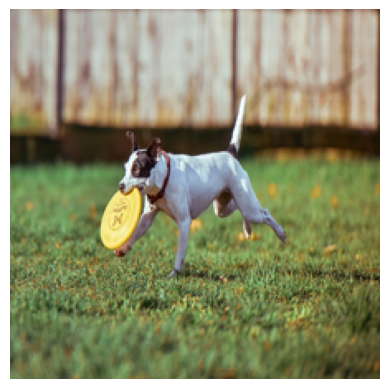

入力画像: adorable-1849992_1920.jpg
出力キャプション: <start> a dog holds a mouth up to catch a frisbee in mouth <end>


入力画像: africa-1170179_1920.jpg
出力キャプション: <start> a herd of giraffe standing in a field together in the background <end>


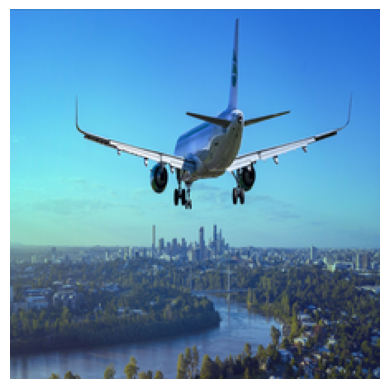

入力画像: airplane-3702676_1920.jpg
出力キャプション: <start> a large jetliner flying over the side of a lush green field <end>


入力画像: automotive-1846910_1920.jpg
出力キャプション: <start> a car driving down a street with a car on the it <end>


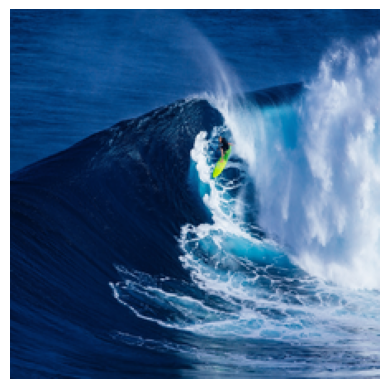

入力画像: beach-1837030_1920.jpg
出力キャプション: <start> a man riding a surfboard in the middle of a large wave <end>


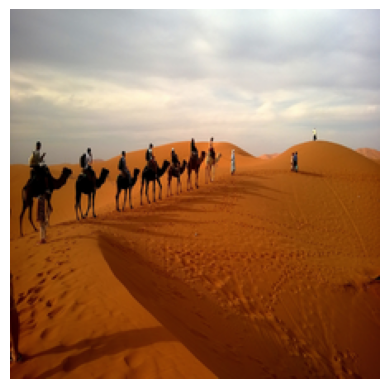

入力画像: caravan-339564_1920.jpg
出力キャプション: <start> a group of people riding on a horse next to a beach <end>


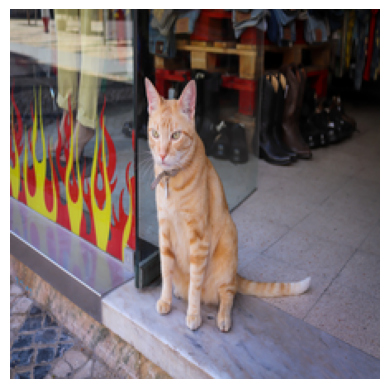

入力画像: cat-4467818_1920.jpg
出力キャプション: <start> a cat sitting on the side of a street near a building <end>


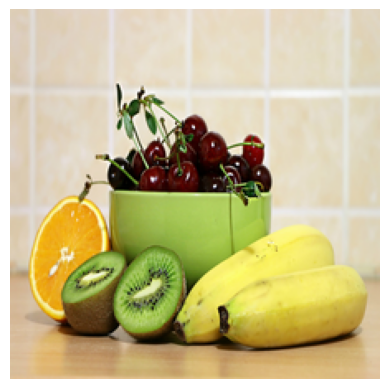

入力画像: cherry-1468933_1920.jpg
出力キャプション: <start> a bowl of fruit and a banana sitting on a table top <end>


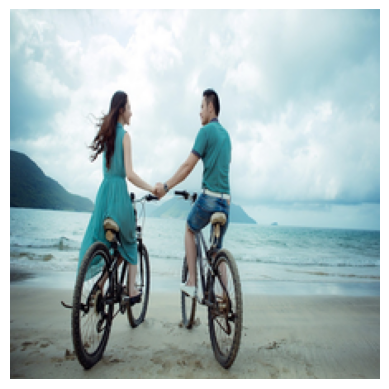

入力画像: couple-955926_1280.jpg
出力キャプション: <start> a woman in a bikini riding her bike on the beach shore <end>


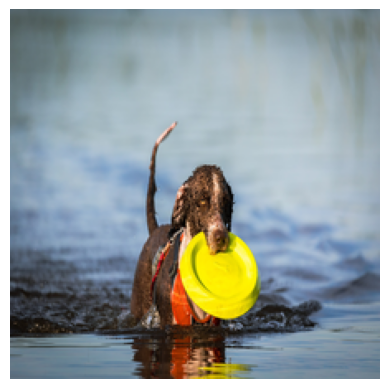

入力画像: dog-7367949_1920.jpg
出力キャプション: <start> a dog in the air with a frisbee in its mouth open <end>


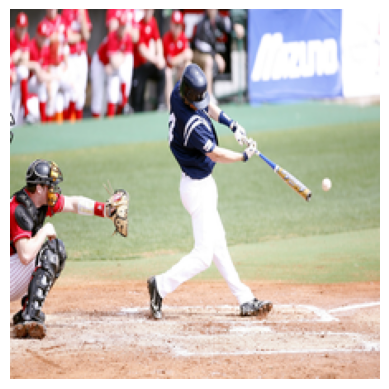

入力画像: hit-1407826_1920.jpg
出力キャプション: <start> a baseball player holding a bat while standing on the baseball field <end>


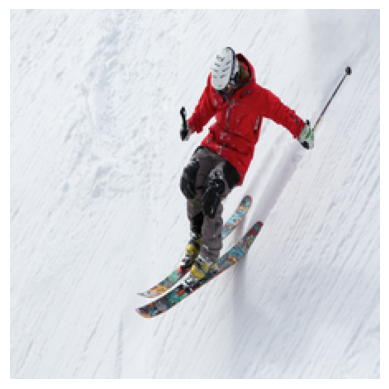

入力画像: man-498473_1920.jpg
出力キャプション: <start> a man in a suit on a snow board in the snow <end>


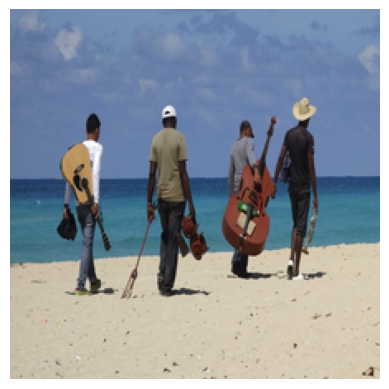

入力画像: musician-743973_1920.jpg
出力キャプション: <start> a group of people and bathing suits standing on the beach with surfboards <end>


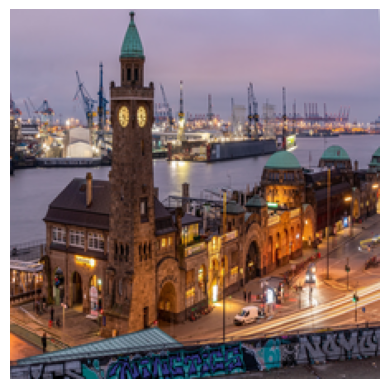

入力画像: port-5788261_1920.jpg
出力キャプション: <start> a large building with a clock and a clock on it tower <end>


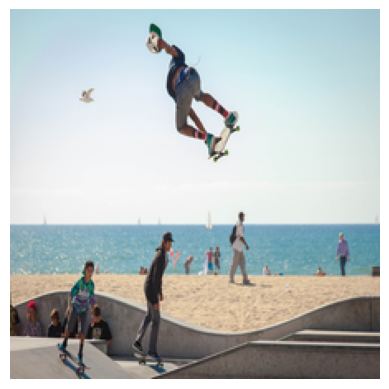

入力画像: profile-7579739_1920.jpg
出力キャプション: <start> a man riding a skateboard on a ramp on a sunny day <end>


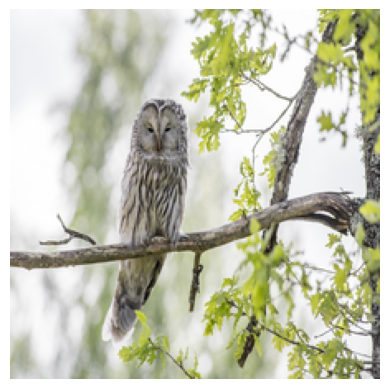

入力画像: ural-owl-4808774_1920.jpg
出力キャプション: <start> a bird perched on a branch with a tree in the background <end>


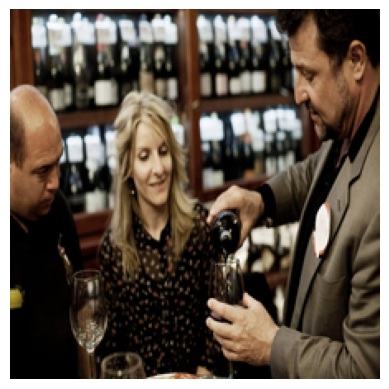

入力画像: wine-bar-2139973_1920.jpg
出力キャプション: <start> a man in a suit holding a doughnut in a right hand <end>


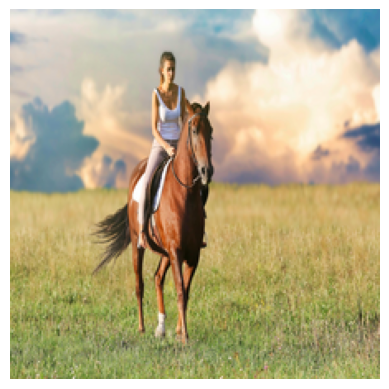

入力画像: woman-3432069_1920.jpg
出力キャプション: <start> a brown horse standing in a field next to a forest <end>


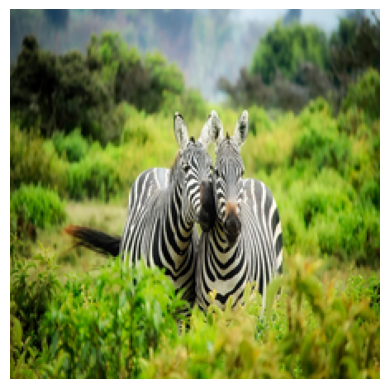

入力画像: zebras-1883654_1920.jpg
出力キャプション: <start> a zebra standing on top of a green field in a grass <end>


In [26]:
demo()

In [31]:
import torch


lengths = torch.randint( low = 1, high = 20, size=(10,))

iter_max = 10

for i in range( iter_max - 1 ):
    # デコーダに入力する
    #print( "size of outputs:{}".format( outputs.size() ) )
    #outputs = outputs.long()
    #print( "outputs size:", outputs.size() )
    #outputs,  _ = self.forward( enc_outs, outputs.to(enc_outs.device), lengths, is_inference = is_inference)
    #print( outputs.size())

    outputs = torch.randn( (10,20,6000))
    
    outputs = torch.nn.functional.softmax( outputs, dim = 2 )
    outputs2 = outputs.clone()
            
    for n in range( outputs.size(0) ):

        '''
        #tmp_outputs = torch.zeros( (outputs.size(1)) )
        #print( "n=", n, "outputs[n,:]:{}".format( outputs[n,:]))
        tmp_outputs = torch.max( outputs[n,:], dim = 1 )[0]
        #print( "tmp_outpus:{}".format( tmp_outputs ))
        print( "0 size of tmp_outpus:{}".format( tmp_outputs.size() ))
        tmp_outputs = torch.sort( tmp_outputs[:], dim = 0 ).values
        print( "1 size of tmp_outpus:{}".format( tmp_outputs.size() ))
        num_zero = torch.sum( tmp_outputs == 0.0 )
        print( " num_zero:", num_zero )
        kosuu = int( ( iter_max - i ) * lengths[n]  / iter_max ) + num_zero
        print( "i=",i, ",n=",n, "lengths[n]=", lengths[n], " kosuu:{}".format( kosuu ) )
        if kosuu - 1 < 0:
            kosuu = 1
        thresh = tmp_outputs[ kosuu - 1 ]
        #print(  "i=",i, ",n=",n,"thresh:{}".format( thresh ) )
        t_indices = torch.max( outputs[n,:,:], dim = 1 ).values  < thresh
        outputs2[n,t_indices,:] = 0
        outputs2[n,t_indices,0] = 1
        #for t in range( int( lengths[n] )):
        #    #print("sum of outputs[n,t]:{}".format( torch.sum( outputs[n,t] ) ) )
        #    if torch.max( outputs[n,t] ) < thresh:
        #    #if torch.max( outputs[n,t] ) <= thresh:
        #        outputs2[n,t,:] = 0
        #        outputs2[n,t,0] = 1
        '''
#outputs = outputs2
outputs = torch.argmax( outputs2, dim = 2 )
print( "i:{}, outputs:{}".format( i, outputs[0] ) )

0 size of tmp_outpus:torch.Size([20])
1 size of tmp_outpus:torch.Size([20])
 num_zero: tensor(0)
i= 0 ,n= 0 lengths[n]= tensor(16)  kosuu:16
0 size of tmp_outpus:torch.Size([20])
1 size of tmp_outpus:torch.Size([20])
 num_zero: tensor(0)
i= 0 ,n= 1 lengths[n]= tensor(3)  kosuu:3
0 size of tmp_outpus:torch.Size([20])
1 size of tmp_outpus:torch.Size([20])
 num_zero: tensor(0)
i= 0 ,n= 2 lengths[n]= tensor(5)  kosuu:5
0 size of tmp_outpus:torch.Size([20])
1 size of tmp_outpus:torch.Size([20])
 num_zero: tensor(0)
i= 0 ,n= 3 lengths[n]= tensor(1)  kosuu:1
0 size of tmp_outpus:torch.Size([20])
1 size of tmp_outpus:torch.Size([20])
 num_zero: tensor(0)
i= 0 ,n= 4 lengths[n]= tensor(5)  kosuu:5
0 size of tmp_outpus:torch.Size([20])
1 size of tmp_outpus:torch.Size([20])
 num_zero: tensor(0)
i= 0 ,n= 5 lengths[n]= tensor(14)  kosuu:14
0 size of tmp_outpus:torch.Size([20])
1 size of tmp_outpus:torch.Size([20])
 num_zero: tensor(0)
i= 0 ,n= 6 lengths[n]= tensor(14)  kosuu:14
0 size of tmp_outpus:

In [29]:
outputs = torch.randn( ( 10, 20, 3000))
outputs2 = outputs.clone()

for n in range( 10 ):
    for t in range( 20 ):
        if torch.max( outputs[n,t] ) < 0.6:
            outputs2[n,t,:] = 0
            outputs2[n,t,0] = 1


In [30]:
for n in range( 10 ):
    a = torch.max( outputs[n,:,:], dim = 1 ).values  > 3.5
    outputs2[n, a, : ] = 0
    outputs2[n, a, 0 ] = 1
    
print( outputs2 )

tensor([[[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.1608, -0.0955,  0.4458,  ..., -2.2006,  1.2333, -0.1460],
         [ 0.1897, -1.6288,  0.2451,  ...,  0.0152, -0.1650, -1.4625],
         ...,
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.8785, -1.1804,  0.7450,  ..., -2.6149, -0.4137,  0.7723],
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.7991,  0.0265,  0.7618,  ..., -0